# The modelling error is:
$$\delta e_{sys} = (e-e_{PSF}) \left( \frac{T_{PSF}}{T_{gal}} \right) \frac{\delta T_{PSF}}{T_{PSF}} - \left( \frac{T_{PSF}}{T_{gal}} \right)\delta e_{PSF}$$


## Propagate into shear errors:
$\rho$ statistics:

$$\rho_1 = \left\langle \delta e_{PSF}^*(x) \; \delta e_{PSF} (x+\theta) \right\rangle$$

$$\rho_2 = \left\langle e_{PSF}^* (x) \; \delta e_{PSF} (x+\theta) \right\rangle $$
$$\rho_3 = \left\langle \left( e_{PSF}^*   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x) \; \left(e_{PSF}   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_4 = \left\langle \delta e_{PSF}^* (x)\;\left( e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_5 = \left\langle e_{PSF}^* (x)\; \left(e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta) \right\rangle $$

Then

$$\delta \xi_+ (\theta) = 2 \left\langle \frac{T_{PSF}}{T_{gal}} \frac{\delta T_{PSF}}{T_{PSF}} \right\rangle \xi_+(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_1(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_2(\theta) 
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_3(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_4(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_5(\theta) 
$$

In [341]:
from __future__ import division
%pylab inline
from angles import r2d, r2arcs, d2arcs
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr, healpy as hp
import treecorr
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 18,12
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from collections import defaultdict
from itertools import chain
sns.set_context('poster',font_scale=1.7)

class ModelErrors():
    
    def __init__(self,ModelType,WorstCase):
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.PSF.TrM = self.TrM
        self.STAR.TrM = self.TrM
        self.alpha = None 
        self.ModelType = ModelType
        self.survey_area = (np.radians(200),np.radians(50)) # in radians
        self.star_num = 1000
        stars_X = np.random.rand(int(self.star_num))*self.survey_area[0] 
        Y = 0.77*np.random.rand(int(self.star_num))/2 +0.5  #*self.survey_area[1] - self.survey_area[1]
        stars_Y = np.arccos(2*Y-1)-np.pi/2
        stars = np.array((stars_X,stars_Y))
        self.stars = stars.swapaxes(1,0)
        self.DELTA.e = defaultdict(np.array)
        self.DELTA.M = defaultdict(np.array)
        self.STAR.M = defaultdict(np.array)
        self.STAR.e = defaultdict(np.array)
        self.PSF.M = defaultdict(np.array)
        self.PSF.e = defaultdict(np.array)
        self.counter = defaultdict(int)
        self.Worst = WorstCase
        for pos in self.stars:
            self.DELTA.M[tuple(pos)] = np.array([0.,0.,0.])
            self.STAR.M[tuple(pos)] = np.array([0.,0.,0.])
            self.PSF.M[tuple(pos)] = np.array([0.,0.,0.])
        
    class PSF:
        '''empty namespace to organise results into
        '''
        pass
    
    class STAR:
        '''empty namespace to organise results into
        '''
        pass
    
    class DELTA:
        '''empty namespace to organise results into
        '''
        pass

    def getModels(self):
        '''calls one of the model methods to create an overly simplified model, 
        or (N/A yet) imports one
        '''
        print 'creating the models at every dither, this will take a while'
        if self.Worst==False:
            for i in range(len(self.positions)):
                self.BestCase(position_num=i)
        else:
            for i in range(len(self.positions)):
                self.WorstCase(position_num=i)
                if len(self.DELTA.M.keys())==self.star_num:
                    return None
                
    def getPositions(self,sqlWhere,database='/Users/myhome/Downloads/minion_1016_sqlite.db'):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere
        '''
        print 'getting the dither positions from the database'
        opsdb = db.OpsimDatabase(database)
        pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
        pos = np.array(pos)
        if any(row[1] == x for row in pos):
            posRA = zip(*pos)[1]
        if any(row[2] == x for row in pos):
            posDec = zip(*pos)[2]
        pos = np.array((posRA,posDec))
        self.positions = pos.swapaxes(1,0)
        print 'number of stars dither positions: ', len(self.positions)
        
    def avgOver(self):
        ''' averages the shapes in 2nd moment-space 
        '''
        if self.Worst==False:
            print 'averaging down and calculating residuals'
            self.PSF.M = {k:self.PSF.M[k]/self.counter[k] for k in self.PSF.M.keys()}
            self.STAR.M = {k:self.STAR.M[k]/self.counter[k] for k in self.STAR.M.keys()}
            self.DELTA.M = {k:self.DELTA.M[k]/self.counter[k] for k in self.counter.keys()}
        elif self.Worst==True:
            print 'calculating residuals'
            self.DELTA.M = {k:self.STAR.M[k]-self.PSF.M[k] for k in self.PSF.M.keys()}
        else:
            raise ValueError('self.Worst is not defined')
            
    def M2e(self):
        ''' go back from 2nd moment space to elipticities
        '''
        print 'moving back from moment space to elipticities'
        for pos in self.PSF.M.keys():
            Mxx, Mxy, Myy = self.DELTA.M[pos]
            self.DELTA.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
            Mxx, Mxy, Myy = self.STAR.M[pos]
            self.STAR.e[pos] = np.array([(Mxx-Myy)/self.STAR.TrM, Mxy*2/self.STAR.TrM])
            Mxx, Mxy, Myy = self.PSF.M[pos]
            self.PSF.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
    
    def process(self,sqlWhere):
        ''' runs all analysis methods 
        '''
        self.getPositions(sqlWhere)
        self.getModels()
        self.avgOver()
        self.M2e()
        self.getRhos()
        if 0:
            self.rhos2errors()
        
        
    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.
        '''
        print 'finding rhos'
        X, Y = np.array(map(lambda i: [key[i] for key in self.DELTA.e.keys()], (0,1)))
        de1, de2 = np.array(map(lambda i:[val[0] for val in self.DELTA.e.values()], (0,1)))
        psfe1, psfe2 = np.array(map(lambda i: [key[i] for key in self.PSF.e.keys()], (0,1)))
            
        decat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        psfcat = treecorr.Catalog(g1=psfe1, g2=psfe2, ra=X, dec=Y, ra_units='radians', dec_units='radians')

        dedecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        dedecorr.process(decat)
        dede_xip = dedecorr.xip
        dede_xim = dedecorr.xim
        self.rho1_sigma = dedecorr.varxi**0.5
        self.r = np.exp(dedecorr.meanlogr)
        self.rho1 = dede_xip
        self.rho1_im = dede_xim
        

        edecorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
        edecorr.process(psfcat, decat)
        ede_xip = edecorr.xip
        ede_xim = edecorr.xim
        
        self.rho2 = ede_xip
        self.rho2_im = ede_xim
        self.rho2_sigma = edecorr.varxi**0.5
        
        if 0:
            self.size_error_ratio = 0.01

            edtedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
            edtedtcorr.process(psfcat*self.size_error_ratio, psfcat*self.size_error_ratio)
            edtedt_xip = edtedtcorr.xip
            edtedt_xim = edtedtcorr.xim

            self.rho3 = edtedt_xip
            self.rho3_im = edtedt_xim

            deedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
            deedtcorr.process(decat, psfcat*self.size_error_ratio)
            deedt_xip = deedtcorr.xip
            deedt_xim = deedtcorr.xim

            self.rho4 = deedt_xip
            self.rho4_im = deedt_xim

            eedtcorr = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
            eedtcorr.process(psfcat, psfcat*self.size_error_ratio)
            eedt_xip = eedtcorr.xip
            eedt_xim = eedtcorr.xim

            self.rho5 = eedt_xip
            self.rho5_im = eedt_xim
            
            
    def rhos2errors(self):
        ''' propagates rho statistics into shear errors 
        '''
        self.delta_xip = 2 * (self.delta_T_psf/self.T_gal) * self.xip\
                    + (self.T_PSF/self.T_gal)**2 * rho1\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho2\
                    + (self.T_PSF/self.T_gal)**2 * self.rho3\
                    + (self.T_PSF/self.T_gal)**2 * self.rho4\
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho5
                    
    def BestCase(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin
        '''
        
        innerStars, starMxx, starMxy, starMyy, psfMxx, psfMxy, psfMyy = self.makeRadialModel(position_num)
            
        # populate new defaultdict with star/psf M[pos]=(Mxx,Mxy,Myy)
        for i in range(len(innerStars)):
            pos = innerStars[i]
            self.STAR.M[pos] += np.array([starMxx[i],starMxy[i],starMyy[i]])
            self.PSF.M[pos] += np.array([psfMxx[i],psfMxy[i],psfMyy[i]])
            self.DELTA.M[pos] += np.array([starMxx[i]-psfMxx[i],starMxy[i]-psfMxy[i],starMyy[i]-psfMyy[i]])
            
#         self.counter = dict(chain(self.counter.items(),{k:(self.counter[k]+1 if k in self.counter.keys() else 1) for k in innerStars}.items()))
#         self.STAR.M = dict(chain(self.STAR.M.items(),{k:(self.STAR.M[k]+np.array([starMxx[i],starMxy[i],starMyy[i]]) if k in self.STAR.M.keys() else np.array([starMxx[i],starMxy[i],starMyy[i]])) for i,k in enumerate(innerStars)}.items()))
#         self.PSF.M = dict(chain(self.PSF.M.items(),{k:(self.PSF.M[k]+np.array([psfMxx[i],psfMxy[i],psfMyy[i]]) if k in self.PSF.M.keys() else np.array([psfMxx[i],psfMxy[i],psfMyy[i]])) for i,k in enumerate(innerStars)}.items()))
#         self.DELTA.M = dict(chain(self.DELTA.M.items(),{k:self.DELTA.M[k]+np.array([starMxx[i]-psfMxx[i],starMxy[i]-psfMxy[i],starMyy[i]-psfMyy[i]]) if k in self.DELTA.M.keys() else np.array([starMxx[i]-psfMxx[i],starMxy[i]-psfMxy[i],starMyy[i]-psfMyy[i]]) for i,k in enumerate(innerStars)}.items() ))
    
    def WorstCase(self,position_num):
        
        innerStars, starMxx, starMxy, starMyy, psfMxx, psfMxy, psfMyy = self.makeRadialModel(position_num)        
        self.STAR.M = dict(chain(self.STAR.M.items(),{k:np.array([starMxx[i], starMxy[i], starMyy[i]]) for i,k in enumerate(innerStars) if k not in self.STAR.M.keys()}.items()))
        self.PSF.M = dict(chain(self.PSF.M.items(),{k:np.array([psfMxx[i], psfMxy[i], psfMyy[i]]) for i,k in enumerate(innerStars) if k not in self.PSF.M.keys()}.items()))
                
    def makeRadialModel(self,position_num):
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        innerStars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]]
        rel_X, rel_Y = innerStars[:,0] - center[0], innerStars[:,1] - center[1]
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)/2
        stare2 = r*np.sin(2*theta)/2
        psfe1 = stare1/1.03
        psfe2 = stare2/1.03
        innerStars = [tuple(i) for i in innerStars]
        starMxx = 0.5*self.STAR.TrM*(stare1+1)
        starMxy = 0.5*self.STAR.TrM*stare2
        starMyy = 0.5*self.STAR.TrM*(-stare1+1)
        psfMxx = 0.5*self.PSF.TrM*(psfe1+1)
        psfMxy = 0.5*self.PSF.TrM*psfe2
        psfMyy = 0.5*self.PSF.TrM*(-psfe1+1)
        return innerStars, starMxx, starMxy, starMyy, psfMxx, psfMxy, psfMyy

Populating the interactive namespace from numpy and matplotlib


In [342]:
best_case = ModelErrors('radial',WorstCase=False)

In [ ]:
%%timeit
best_case.process(sqlWhere='filter = "r" and night < 4000 \
and fieldRA < {} and fieldDec > {} \
and fieldRA > 0 and fieldDec < 0'.format(np.radians(200), np.radians(-50)))

getting the dither positions from the database


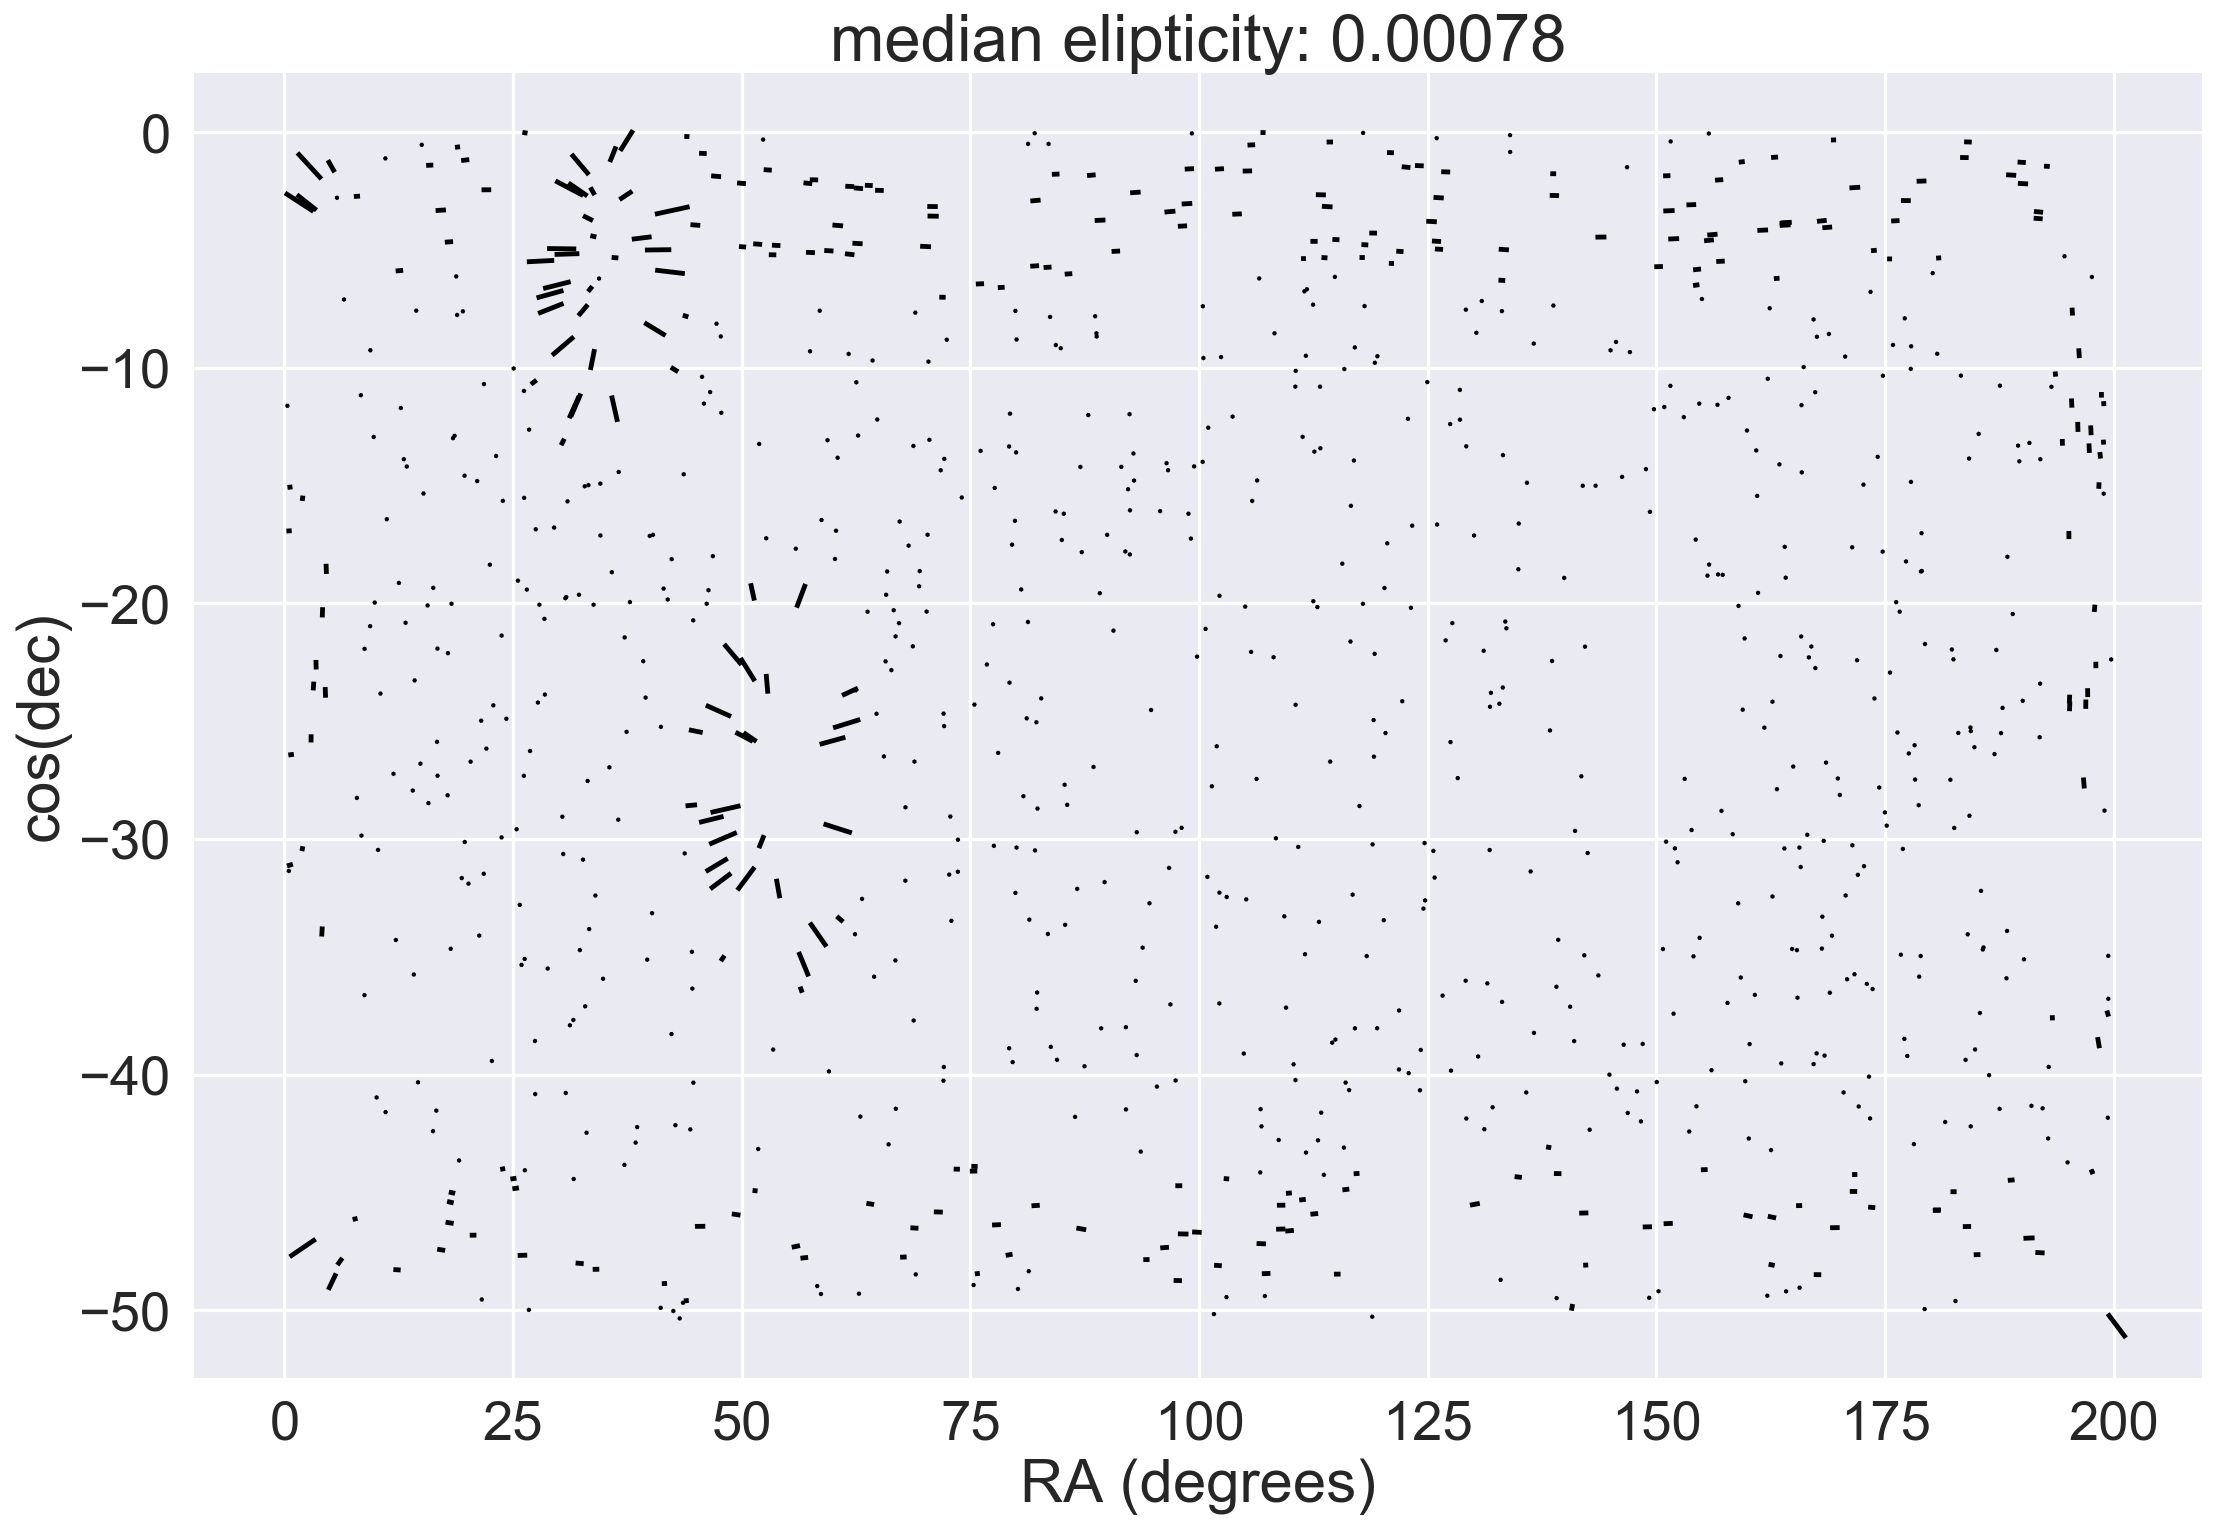

In [334]:
X = np.array(best_case.STAR.e.keys())[:,0]
Y = np.array(best_case.STAR.e.keys())[:,1]
e1 = np.array(best_case.STAR.e.values())[:,0]
e2 = np.array(best_case.STAR.e.values())[:,1]
angles = np.zeros(len(X))
lengths = np.sqrt(e1**2+e2**2)

for i in range(len(lengths)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
U = lengths*np.cos(angles)
V = lengths*np.sin(angles)
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,units='height');
plt.xlabel('RA (degrees)')
plt.ylabel('cos(dec)')
plt.title(r'median elipticity: {:.5f}'.format(np.median(lengths)))

#qk = plt.quiverkey(Q, 0.8, 0.85, 0.005, r'$|e|=0.01$', labelpos='E', coordinates='figure')

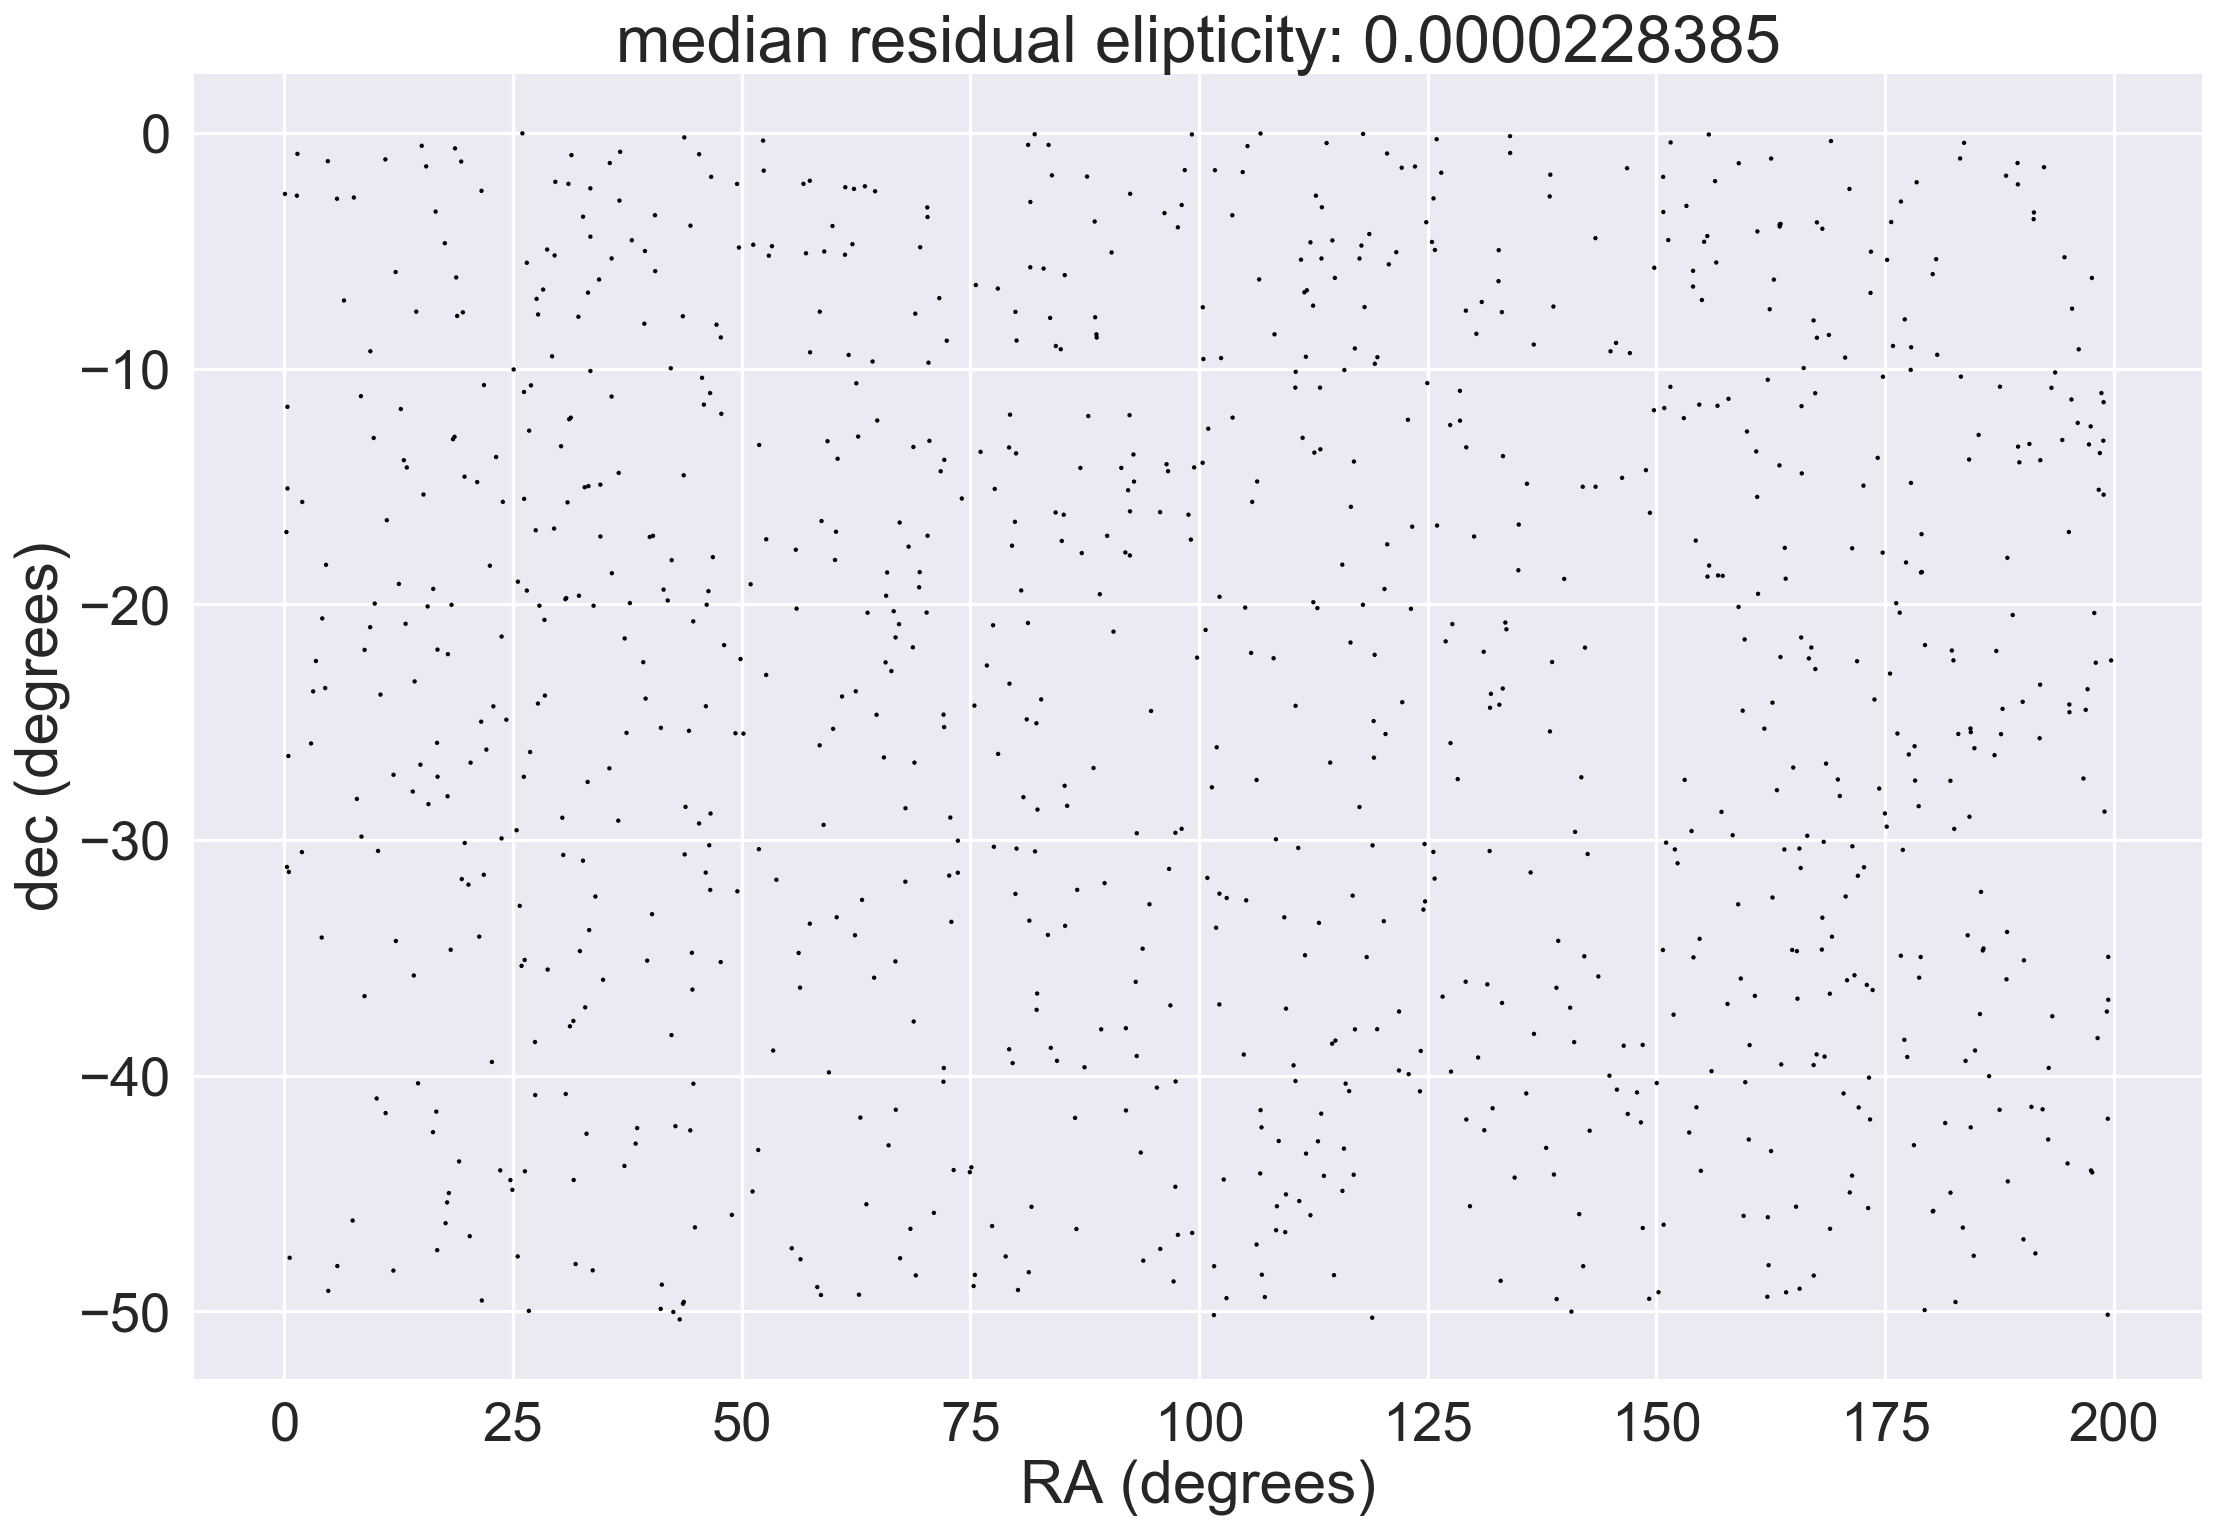

In [335]:
X = np.array(best_case.DELTA.e.keys())[:,0]
Y = np.array(best_case.DELTA.e.keys())[:,1]
e1 = np.array(best_case.DELTA.e.values())[:,0]
e2 = np.array(best_case.DELTA.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
# qk = plt.quiverkey(Q, 0.83, 0.75, 0.01, r'$|\Delta e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: {:.10f}'.format(np.median(U)))

/usr/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


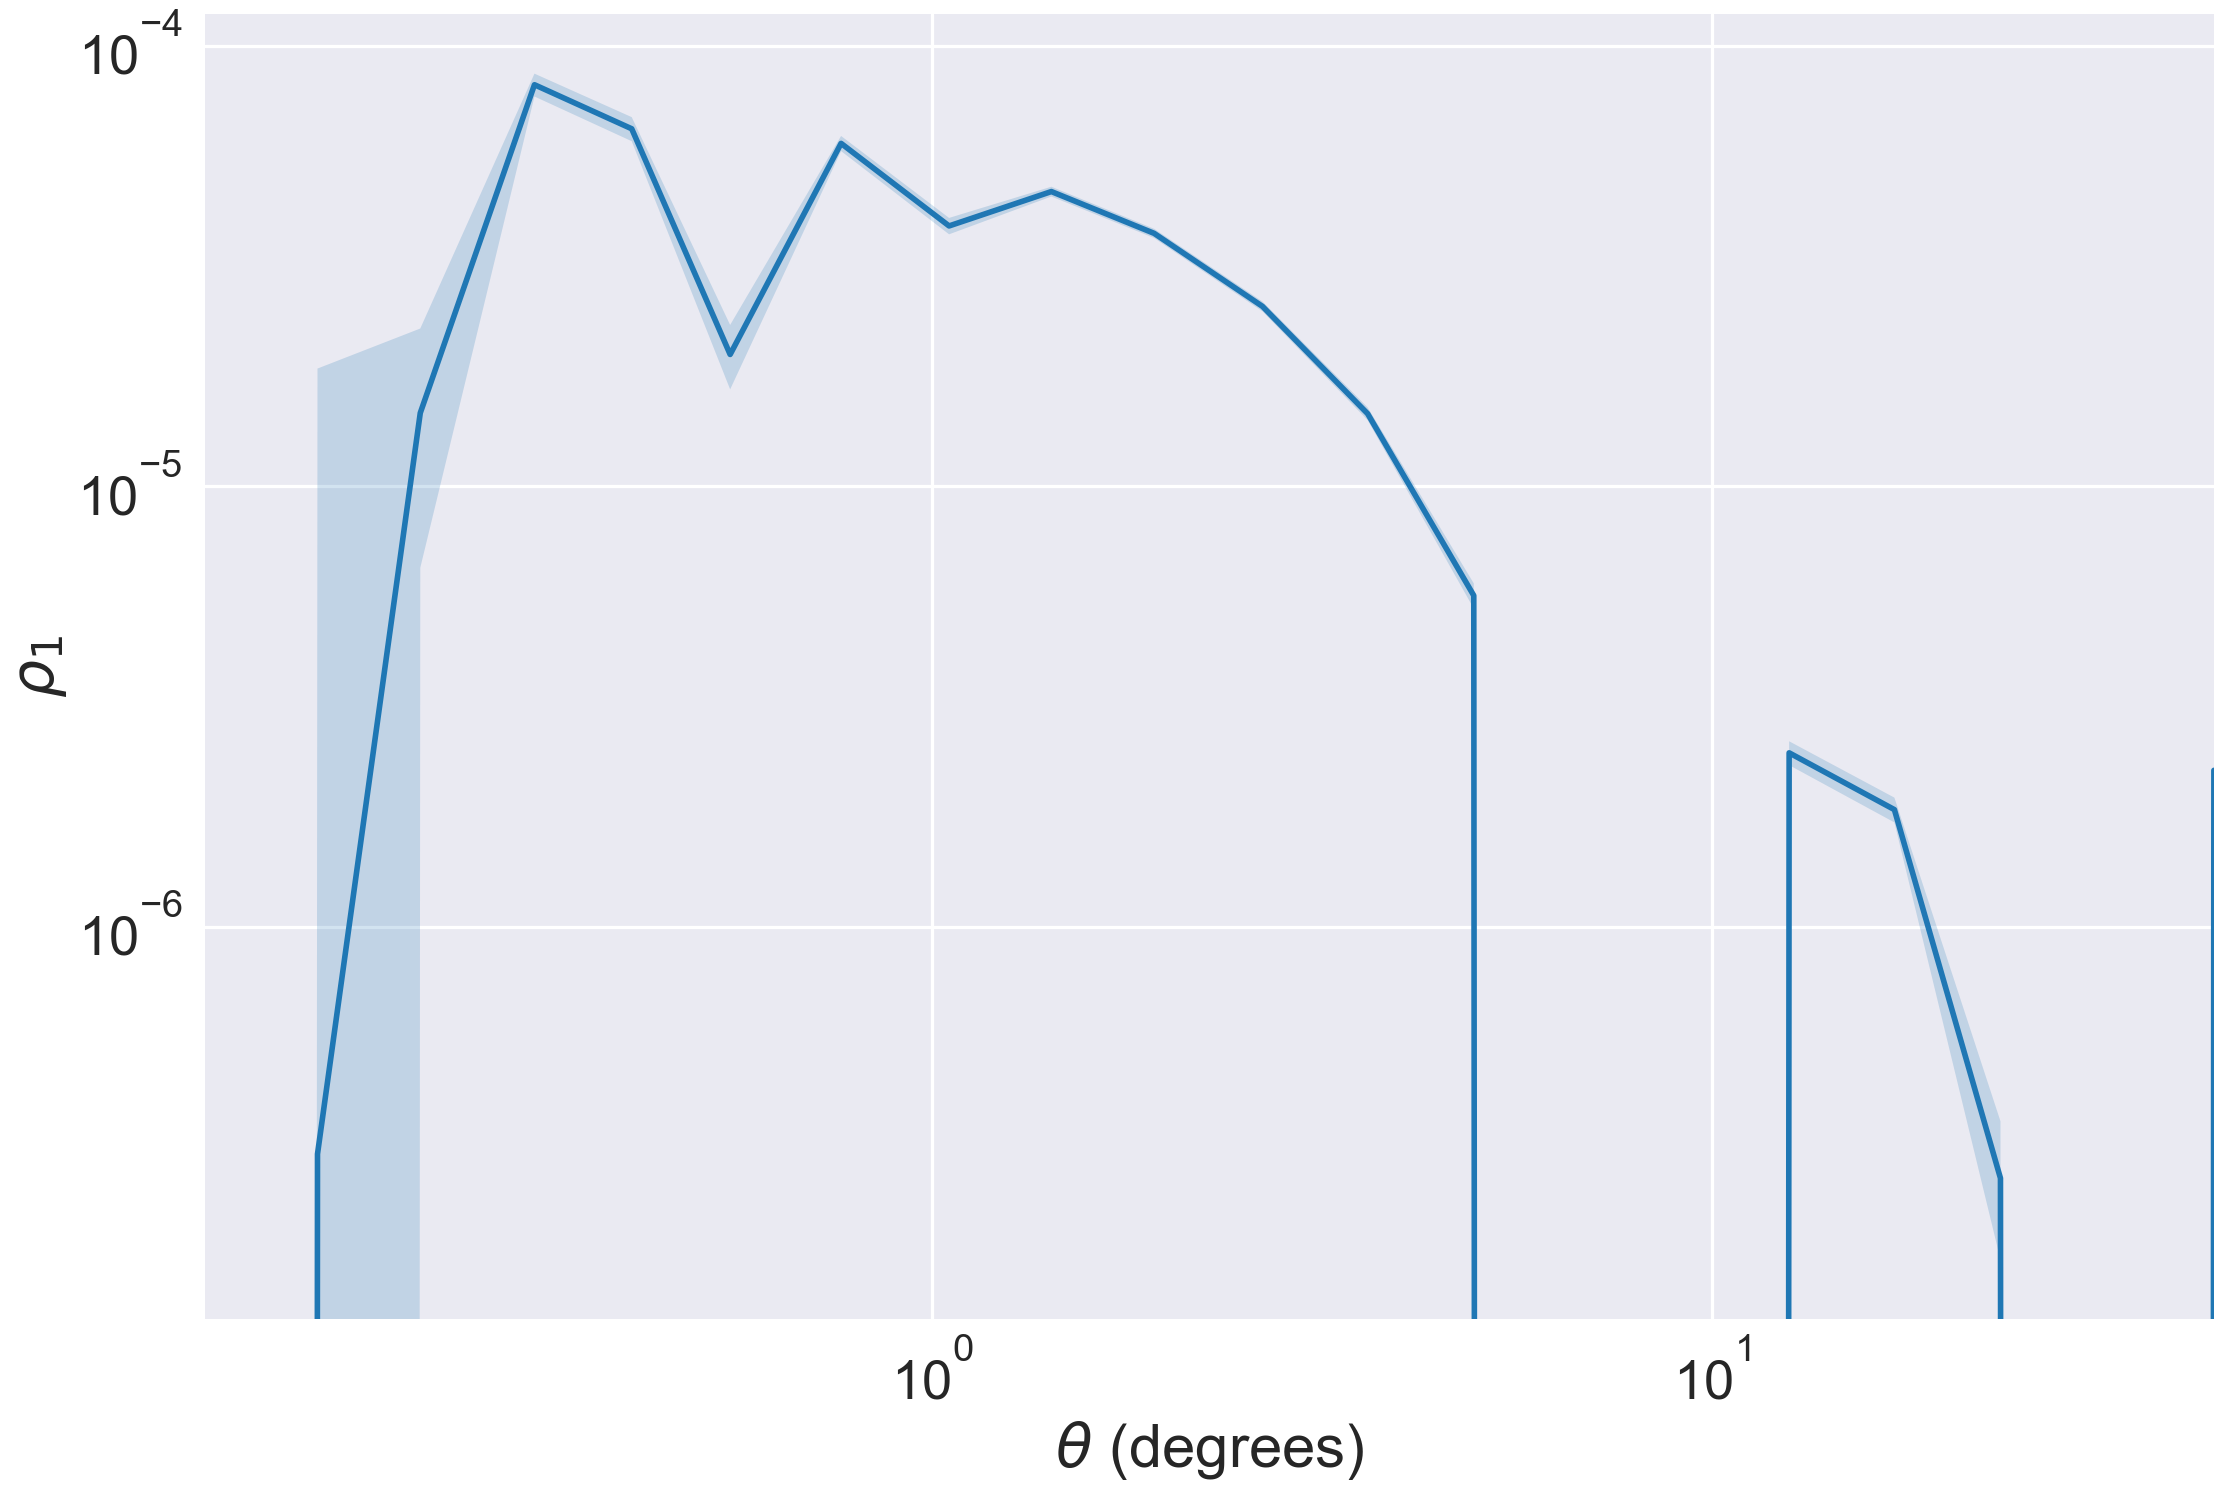

In [54]:
import seaborn
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')
#sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
#plt.yscale('symlog')
#plt.ylim(-1E-5, 1.5E-5)
#plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [ ]:
# make star e about 0.05
# typical size of residual about 0.005 (noise),  systematic error ~3%

In [65]:
# 2 kinds of plots, one with rhos for y1 and one for y10, and one for both years for the same statisticsx

In [ ]:
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = best_case.rho2_sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
#sns.tsplot(best_case.rho1,best_case.r)#,err_style='std_bars')
sns.tsplot(best_case.rho2,best_case.r,err_style='ci_band',color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('symlog')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [297]:
y1 = ModelErrors('radial',WorstCase=False)

In [298]:
y1.process(sqlWhere='filter = "r" and night < 365 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

getting the dither positions from the database
number of stars dither positions:  11422
creating the models at every dither, this will take a while
averaging down and calculating residuals
moving back from moment space to elipticities
finding rhos


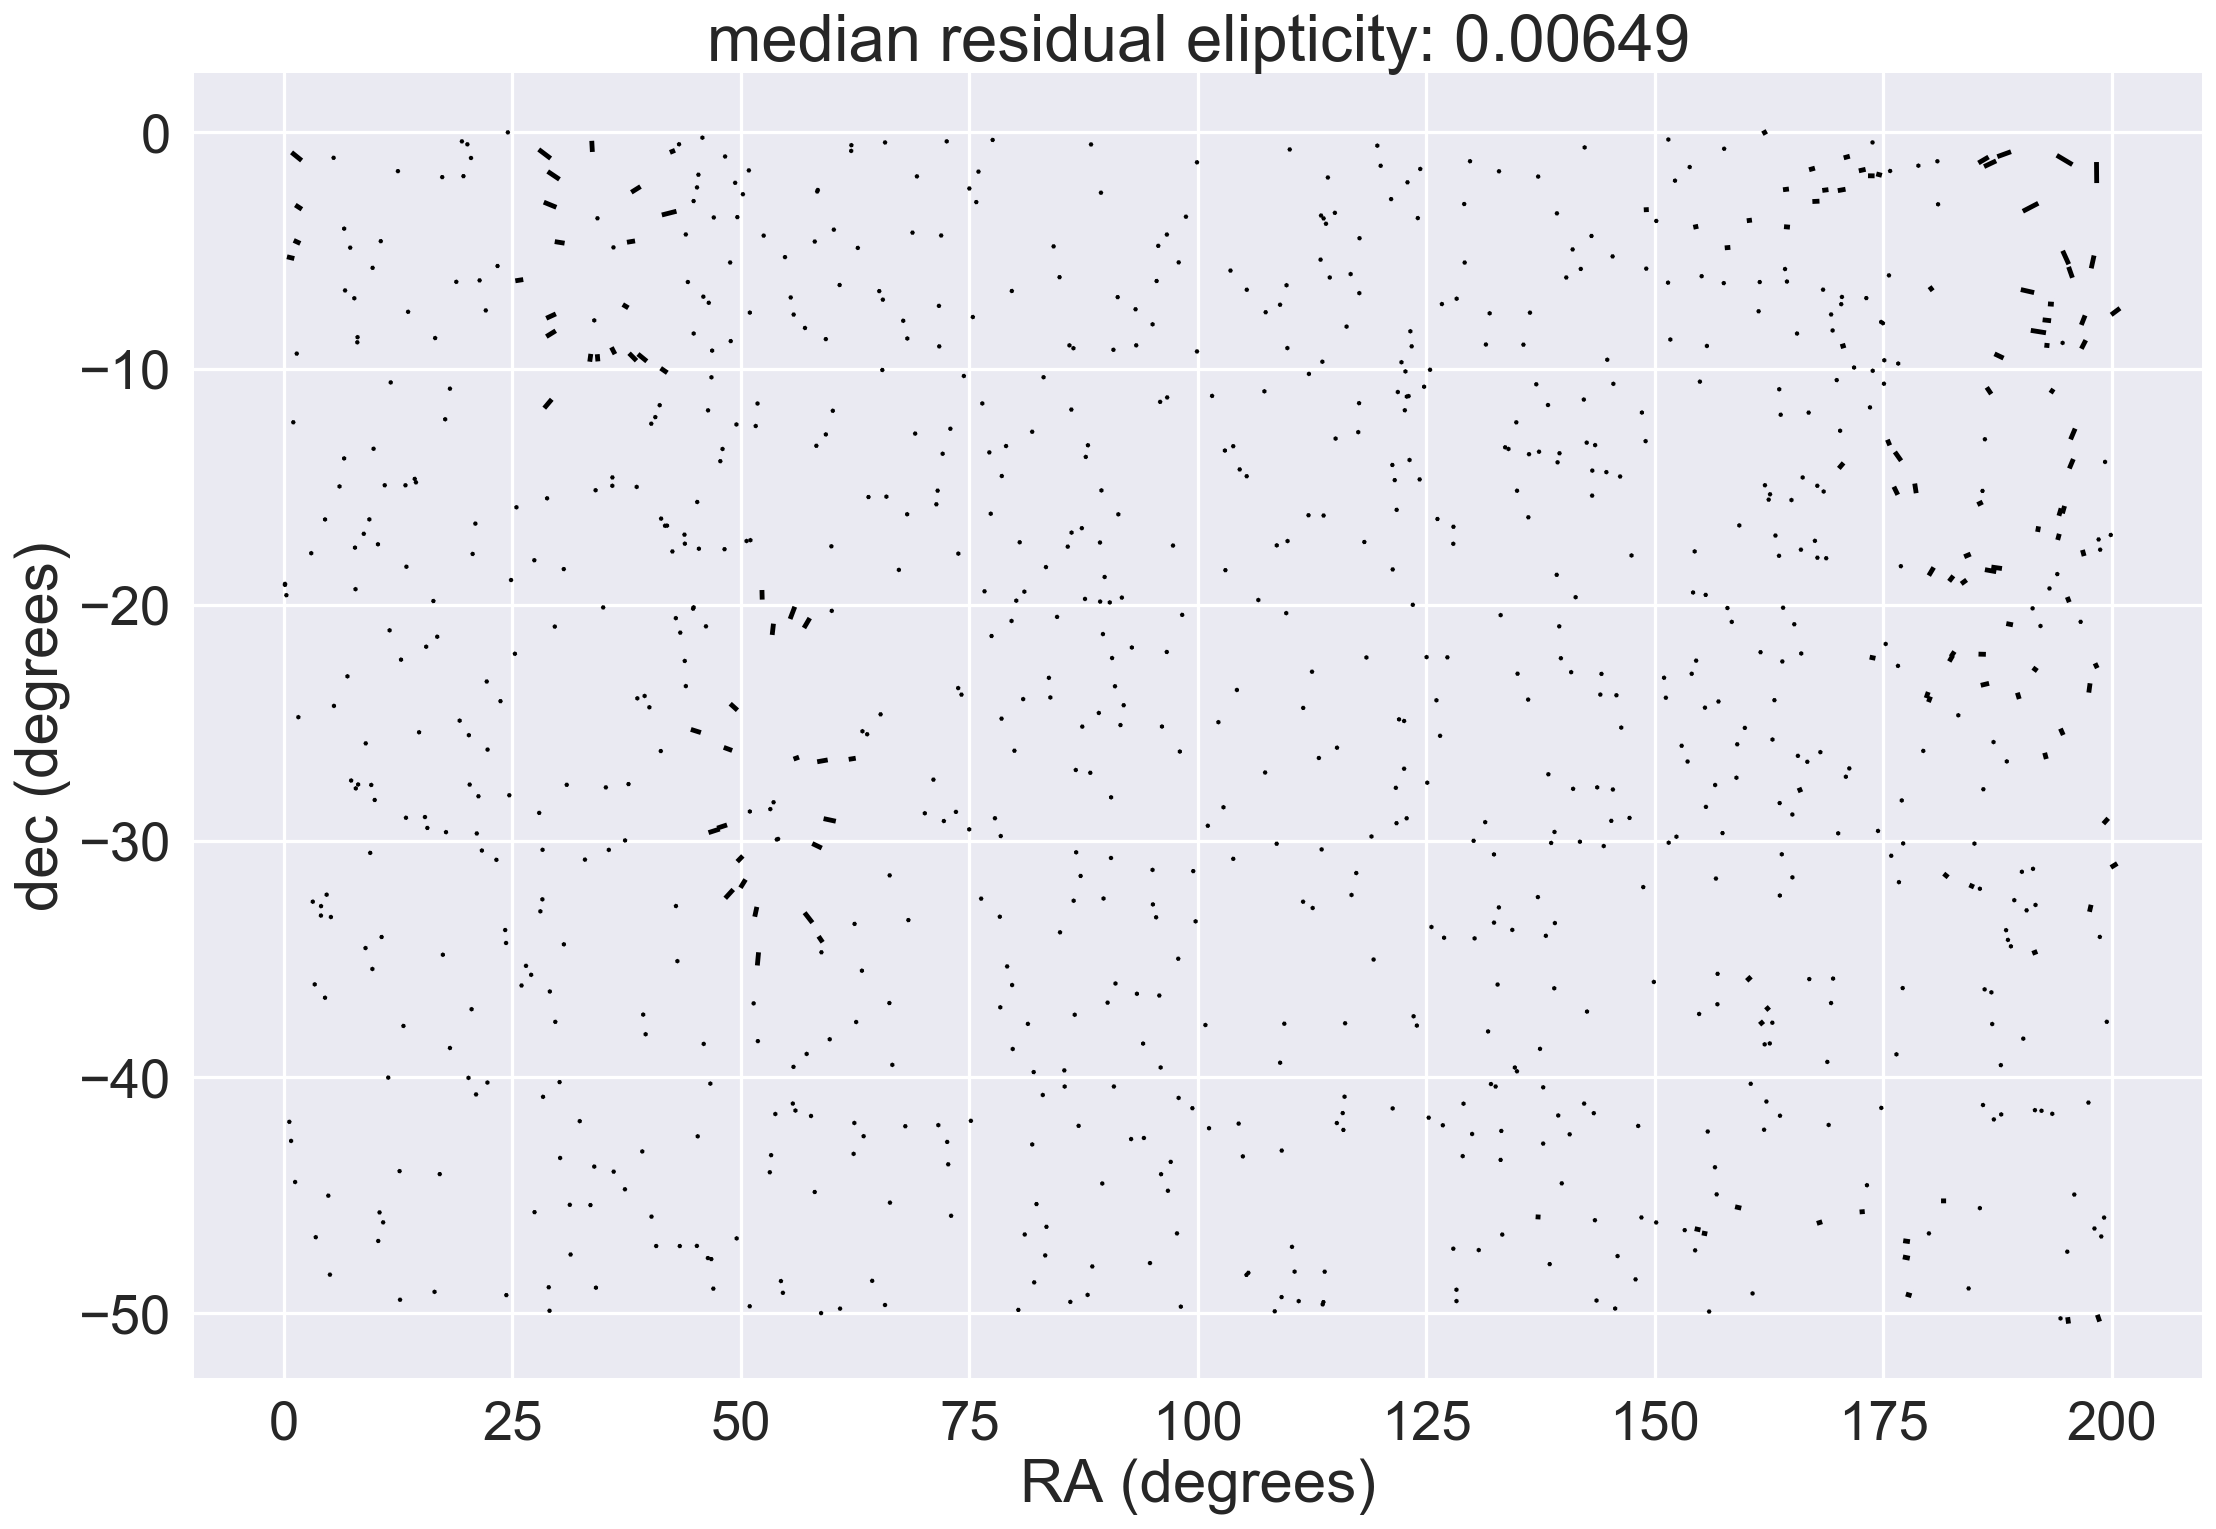

In [300]:
X = np.array(y1.PSF.e.keys())[:,0]
Y = np.array(y1.PSF.e.keys())[:,1]
e1 = np.array(y1.PSF.e.values())[:,0]
e2 = np.array(y1.PSF.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=5,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')

plt.title(r'median residual elipticity: {:.5f}'.format(np.mean(U)))


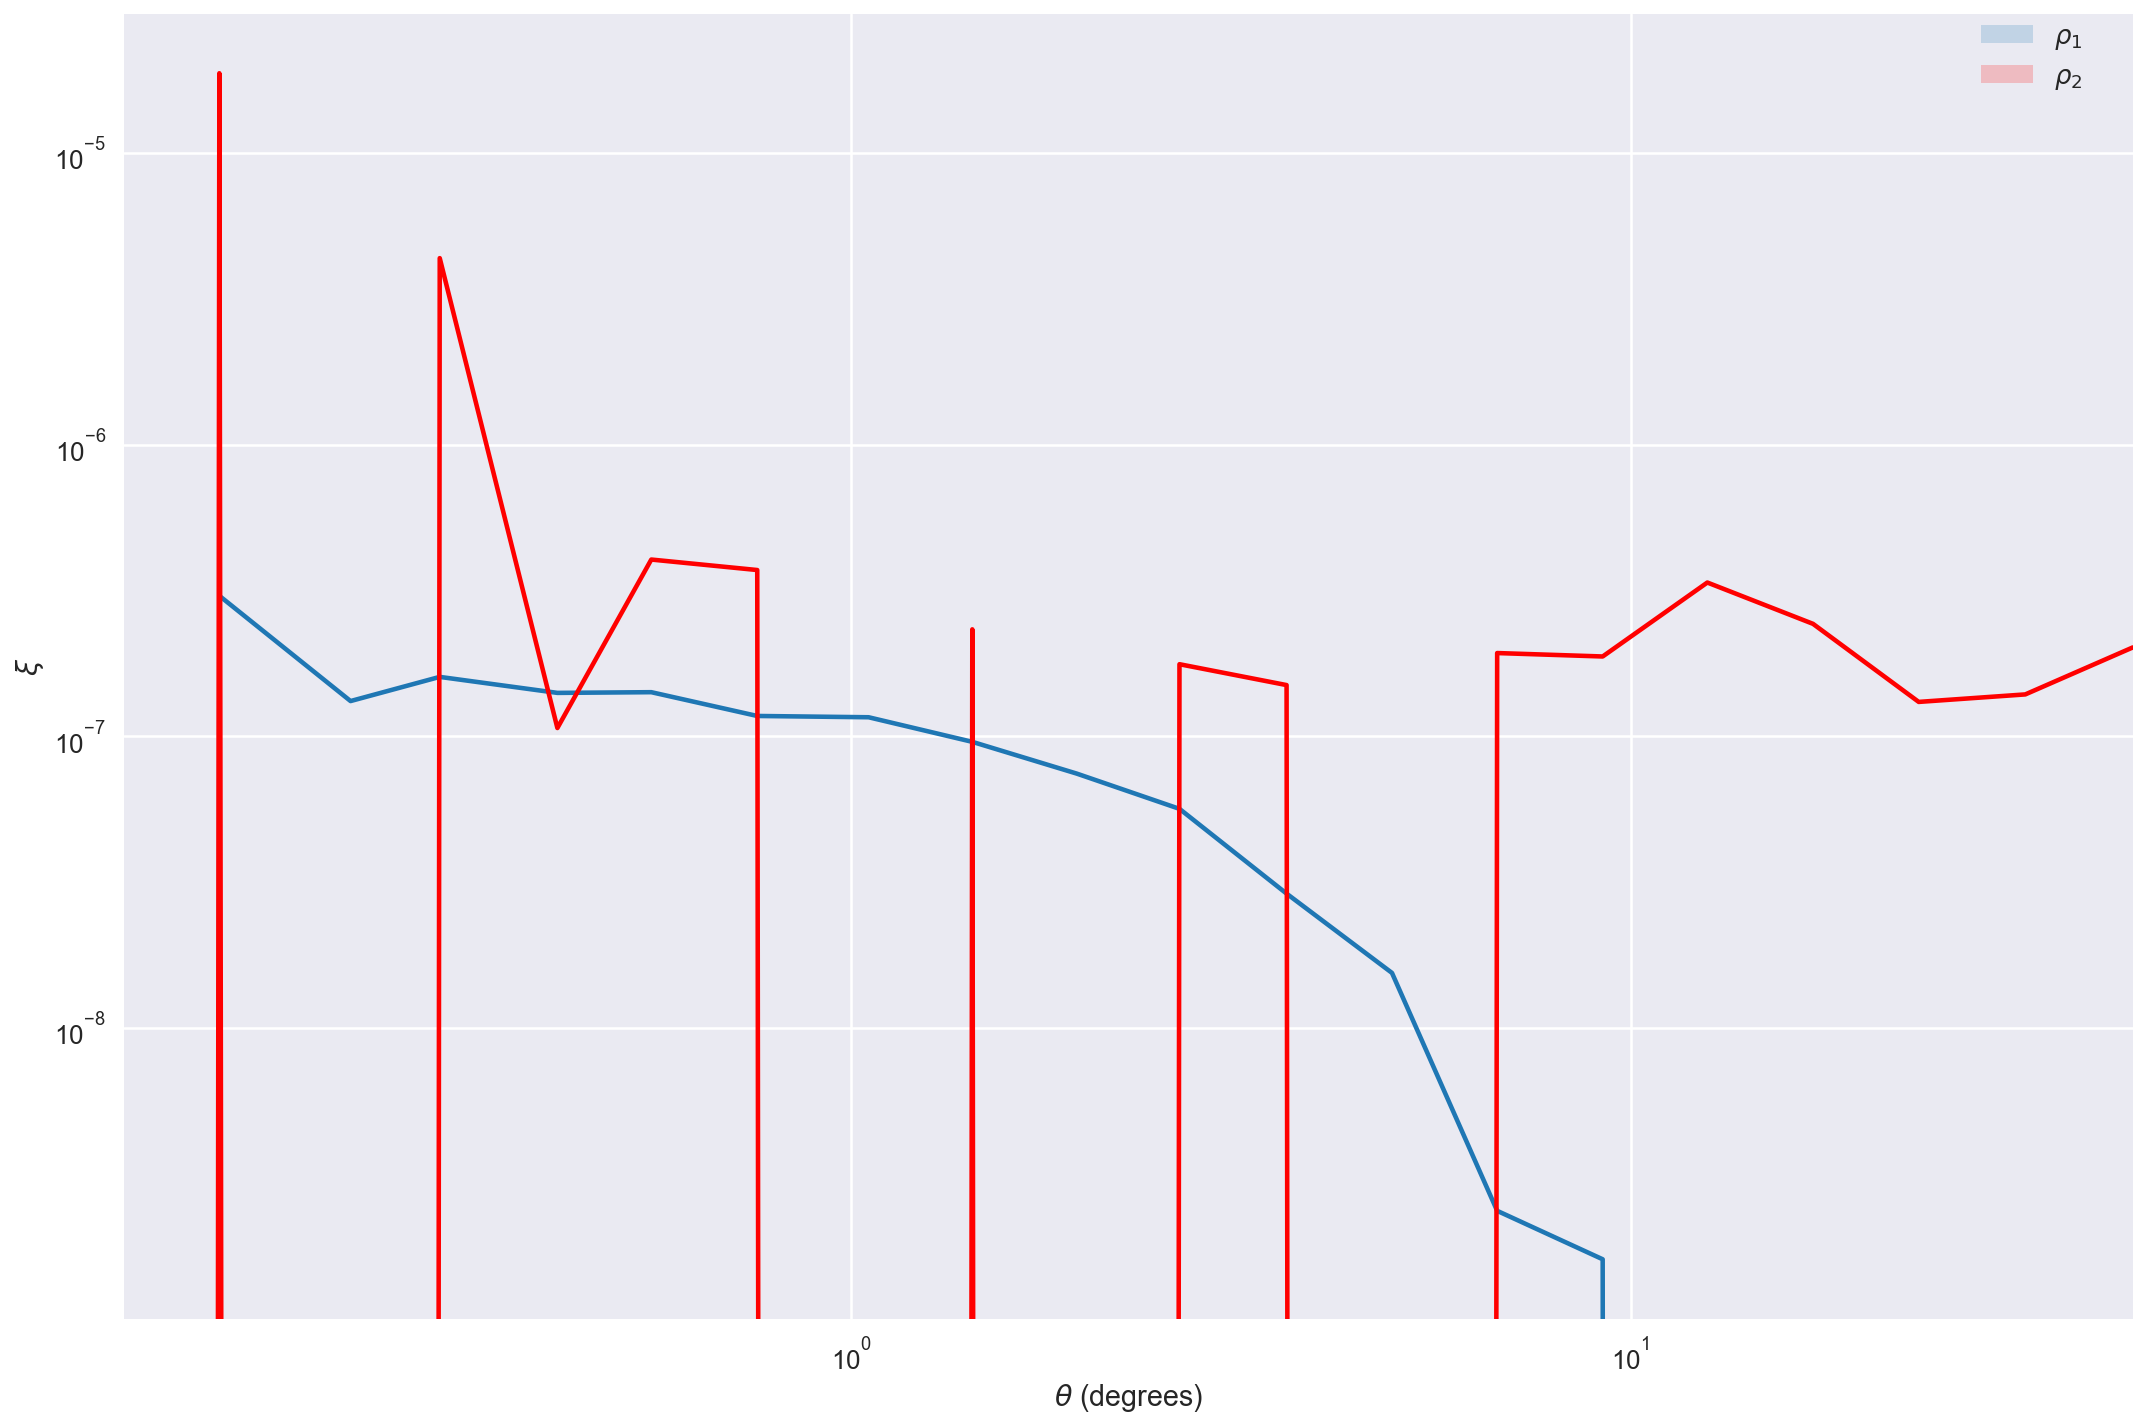

In [139]:
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(y1.rho2,y1.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\rho_1$',r'$\rho_2$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

0.000415505696674


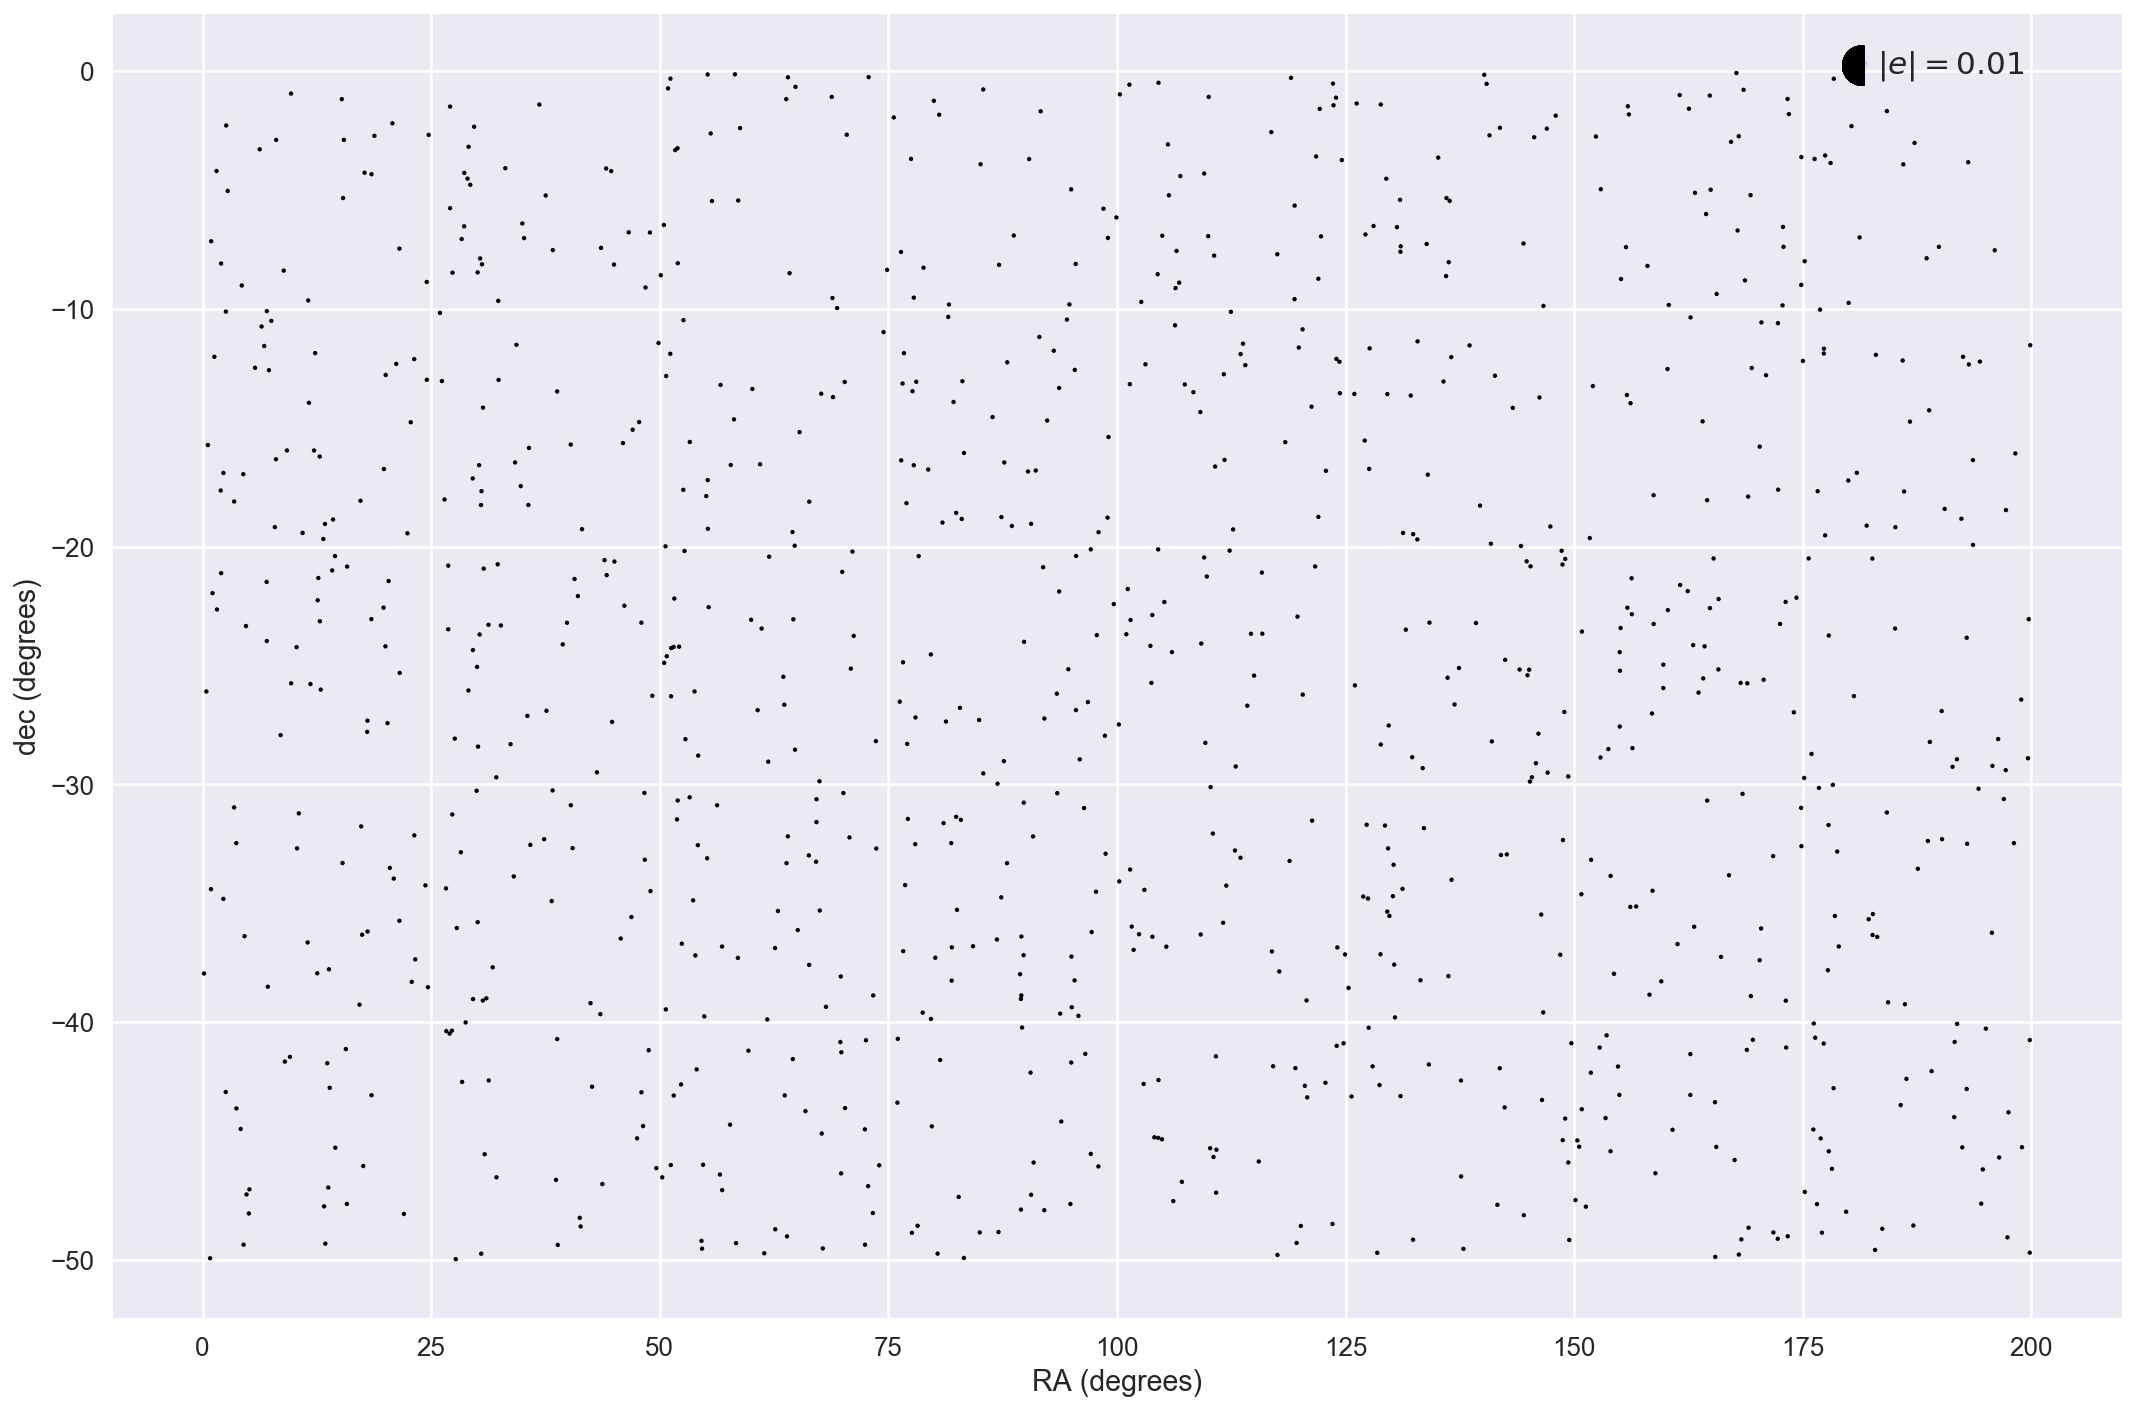

In [188]:
X = np.array(y1.DELTA.e.keys())[:,0]
Y = np.array(y1.DELTA.e.keys())[:,1]
e1 = np.array(y1.DELTA.e.values())[:,0]
e2 = np.array(y1.DELTA.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
# qk = plt.quiverkey(Q, 0.8, 0.85, 0.01, r'$|e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: '+str(np.median(U)))
print np.median(U)

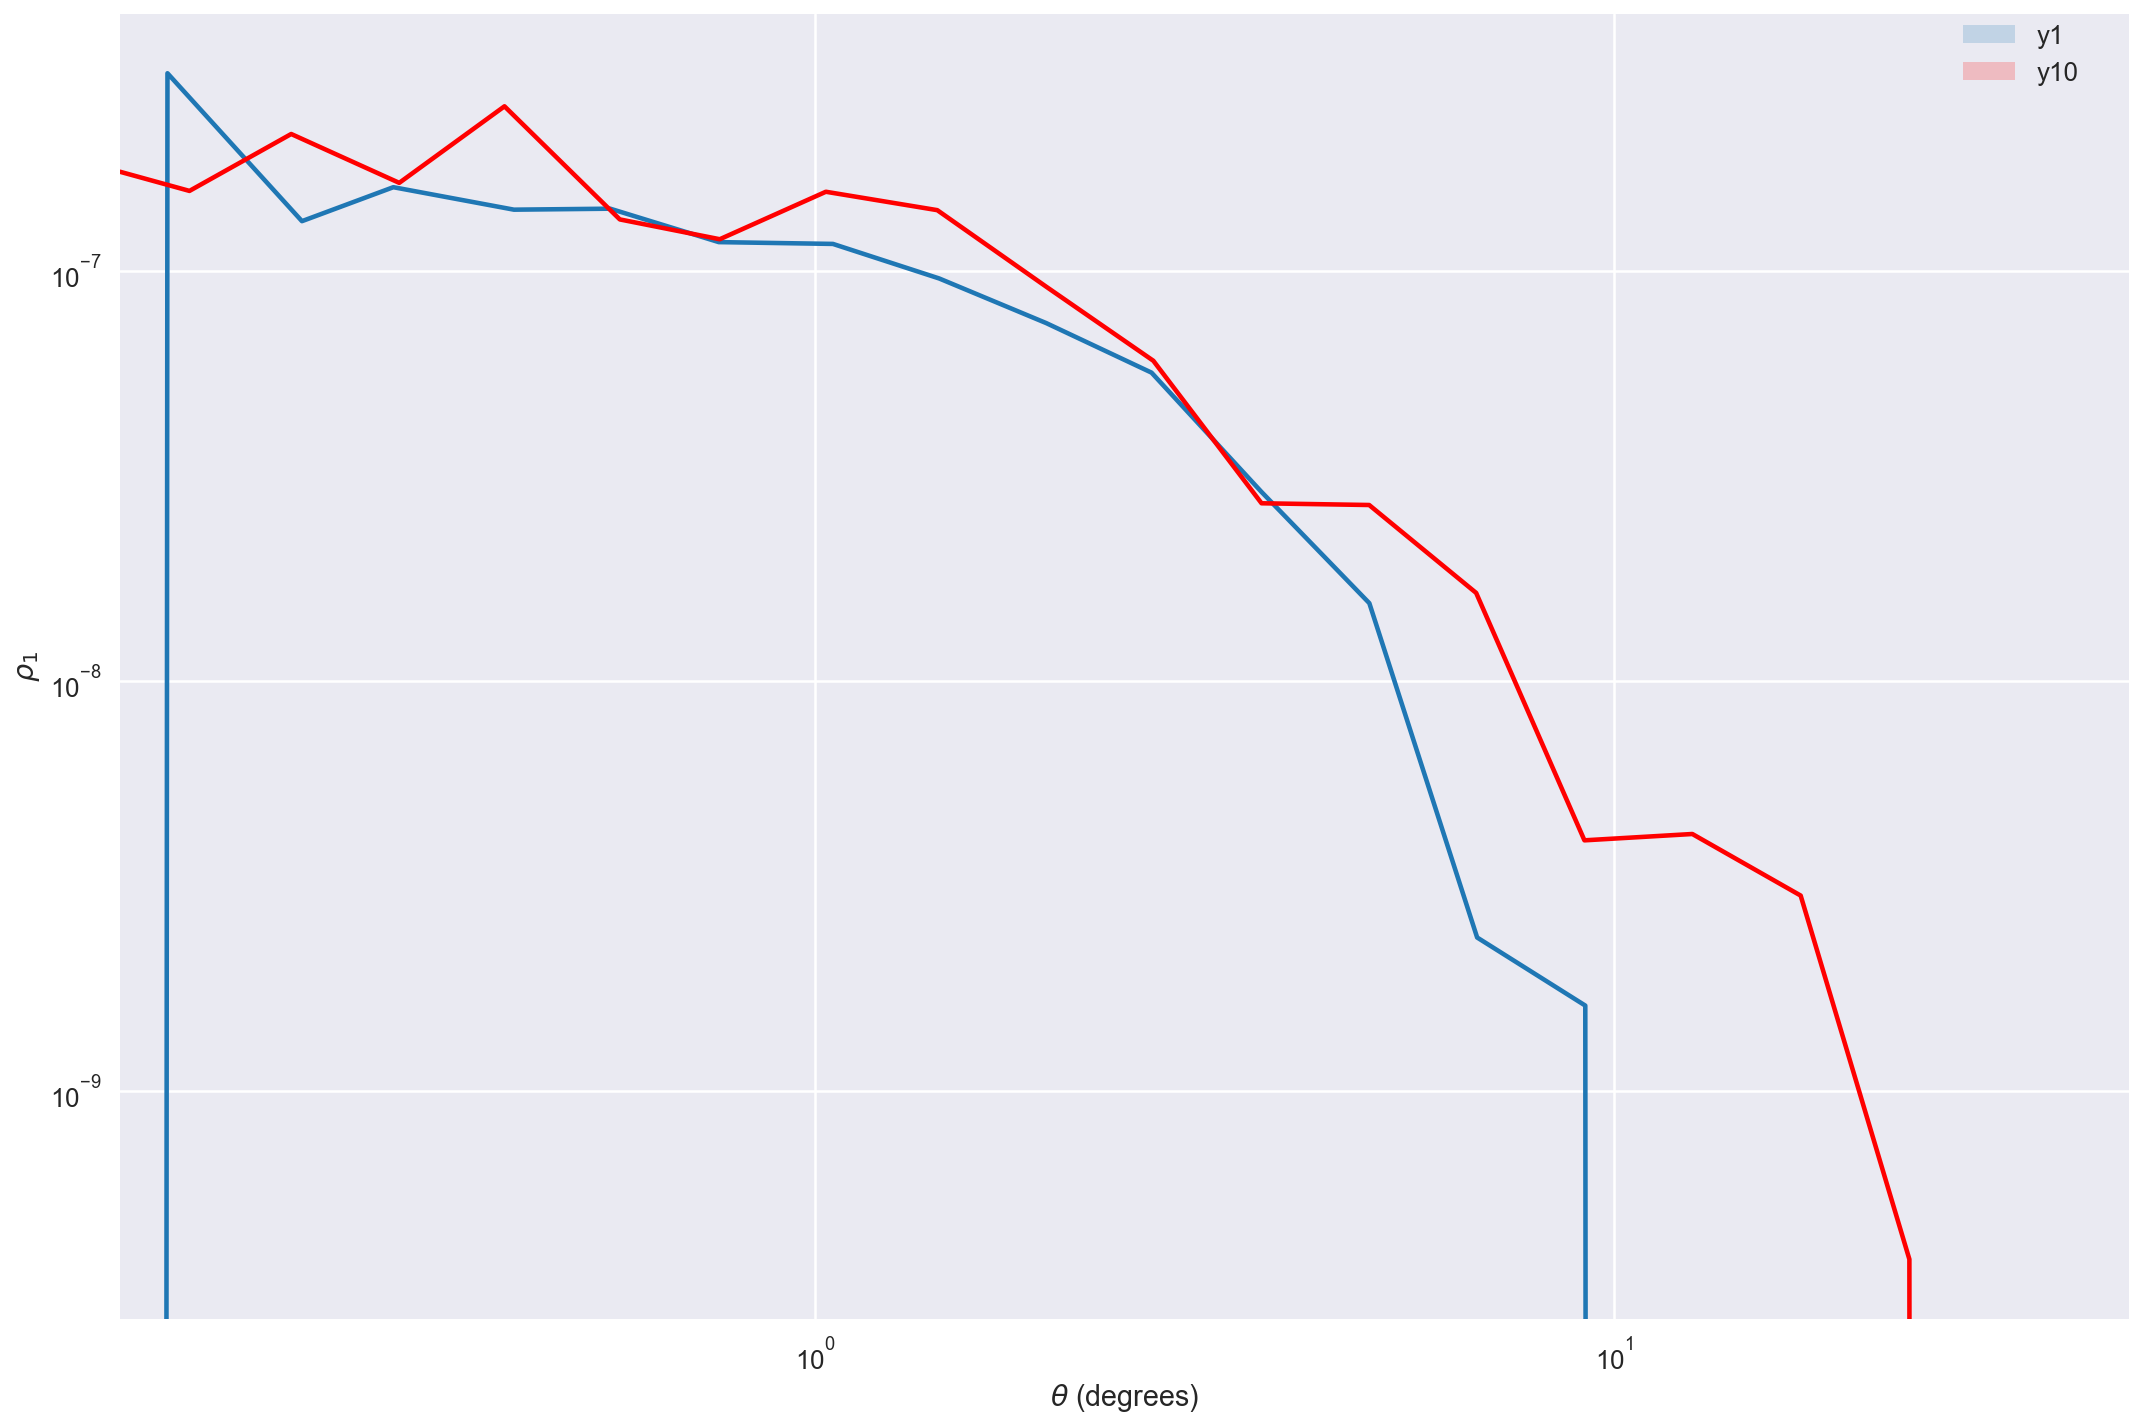

In [142]:
seaborn.timeseries._plot_std_bars = _plot_std_bars
sns.tsplot(y1.rho1,y1.r)#,err_style='std_bars')
sns.tsplot(best_case.rho1,best_case.r,color='r')#,err_style='std_bars')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'y1',r'y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

231968


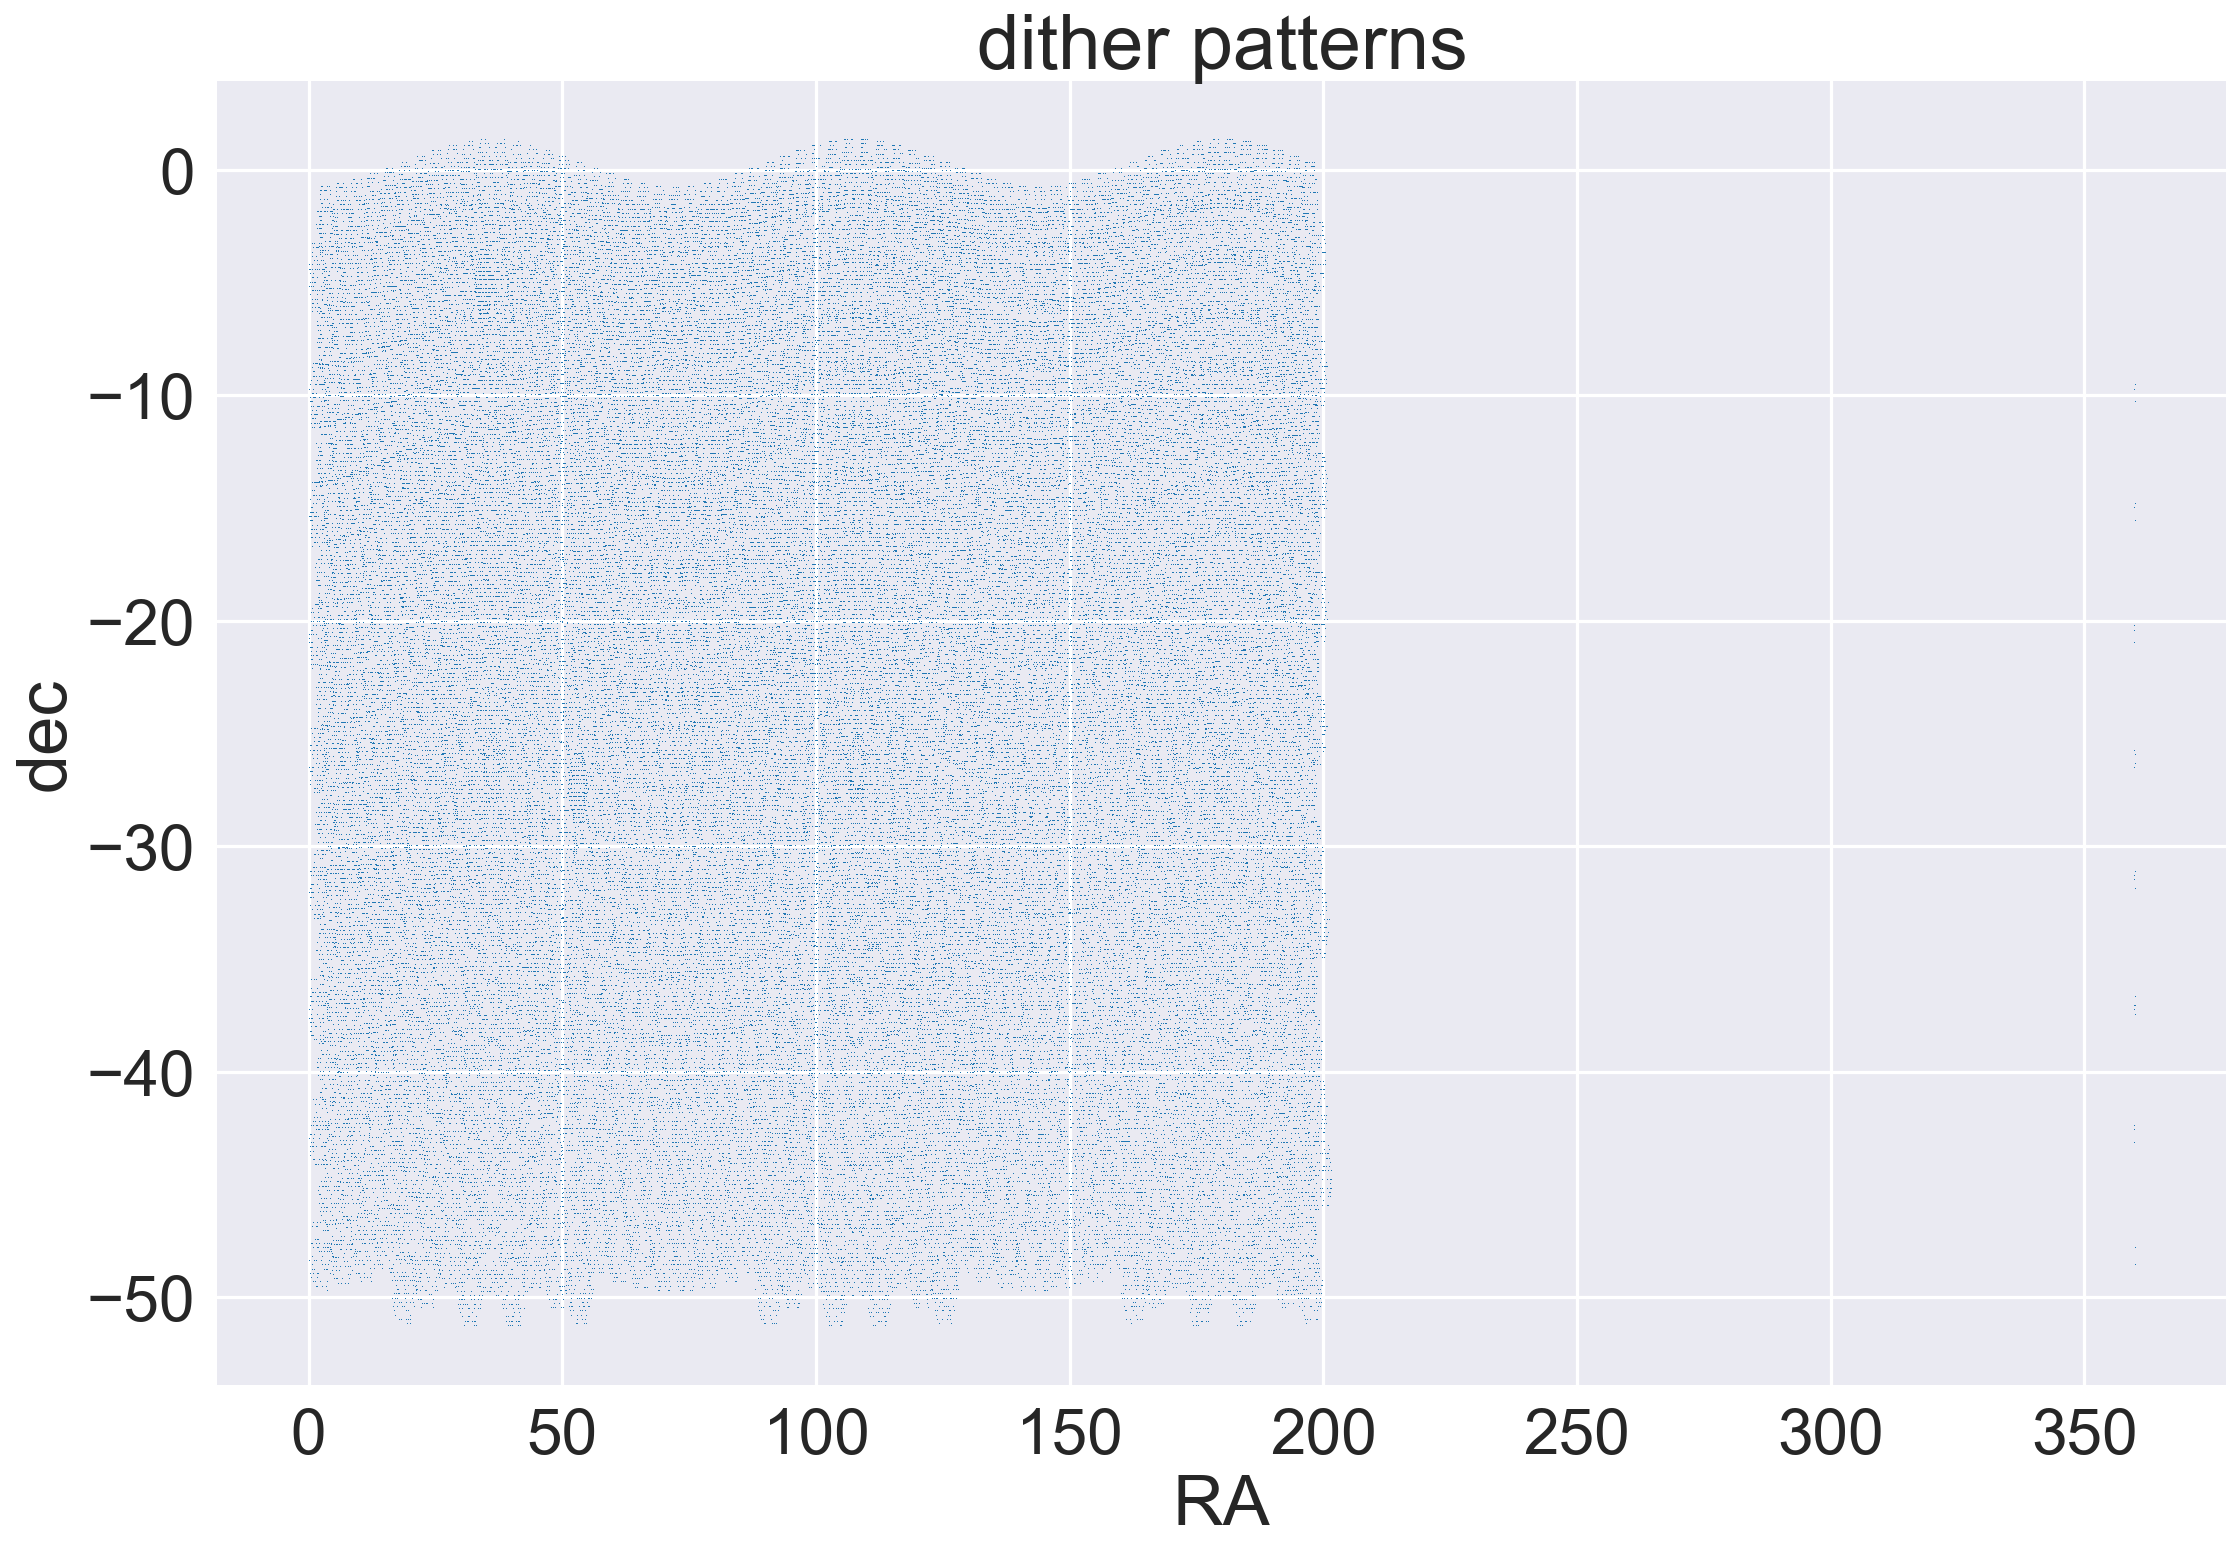

In [38]:
database = '/Users/myhome/Downloads/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(database)

sqlWhere = 'filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50))

pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
pos = np.array(pos)
if any(row[1] == x for row in pos):
    pos2 = zip(*pos)[1]
if any(row[2] == x for row in pos):
    pos3 = zip(*pos)[2]
pos2,pos3 = np.array(map(lambda x: np.array(x)*180/np.pi,(pos2,pos3)))
plt.plot(pos2,pos3,',')
print len(pos2)
plt.xlabel('RA')
plt.ylabel('dec')
plt.title('dither patterns')

In [290]:
worst_case = ModelErrors('radial',True)

In [291]:
worst_case.process(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

getting the dither positions from the database
number of stars dither positions:  231968
creating the models at every dither, this will take a while
calculating residuals
moving back from moment space to elipticities
finding rhos


In [292]:
worst_case.STAR.e

defaultdict(<function numpy.core.multiarray.array>,
            {(0.66015560222553638,
              -0.51292439807217249): array([ 0.04929093,  0.05101505]),
             (2.0149713465218575,
              -0.31580979257489883): array([ 0.04564859, -0.04508802]),
             (1.7477630709601644,
              -0.29591909809518335): array([ 0.03950178, -0.04446937]),
             (0.91684993174464513,
              -0.31220329395592539): array([ 0.06285804,  0.02304152]),
             (1.98153557118834,
              -0.44505314660445805): array([-0.04750889,  0.01373387]),
             (3.030444809337844,
              -0.63863882677518236): array([-0.06546133,  0.00988272]),
             (0.03508214787028343,
              -0.026631021329490911): array([ 0.06407162,  0.01557564]),
             (1.9438310953095783,
              -0.31377782762305628): array([ 0.0443089 ,  0.03502814]),
             (1.1807272348389981,
              -0.61381251702843642): array([-0.07211997, -0.00491

0.0580911948605


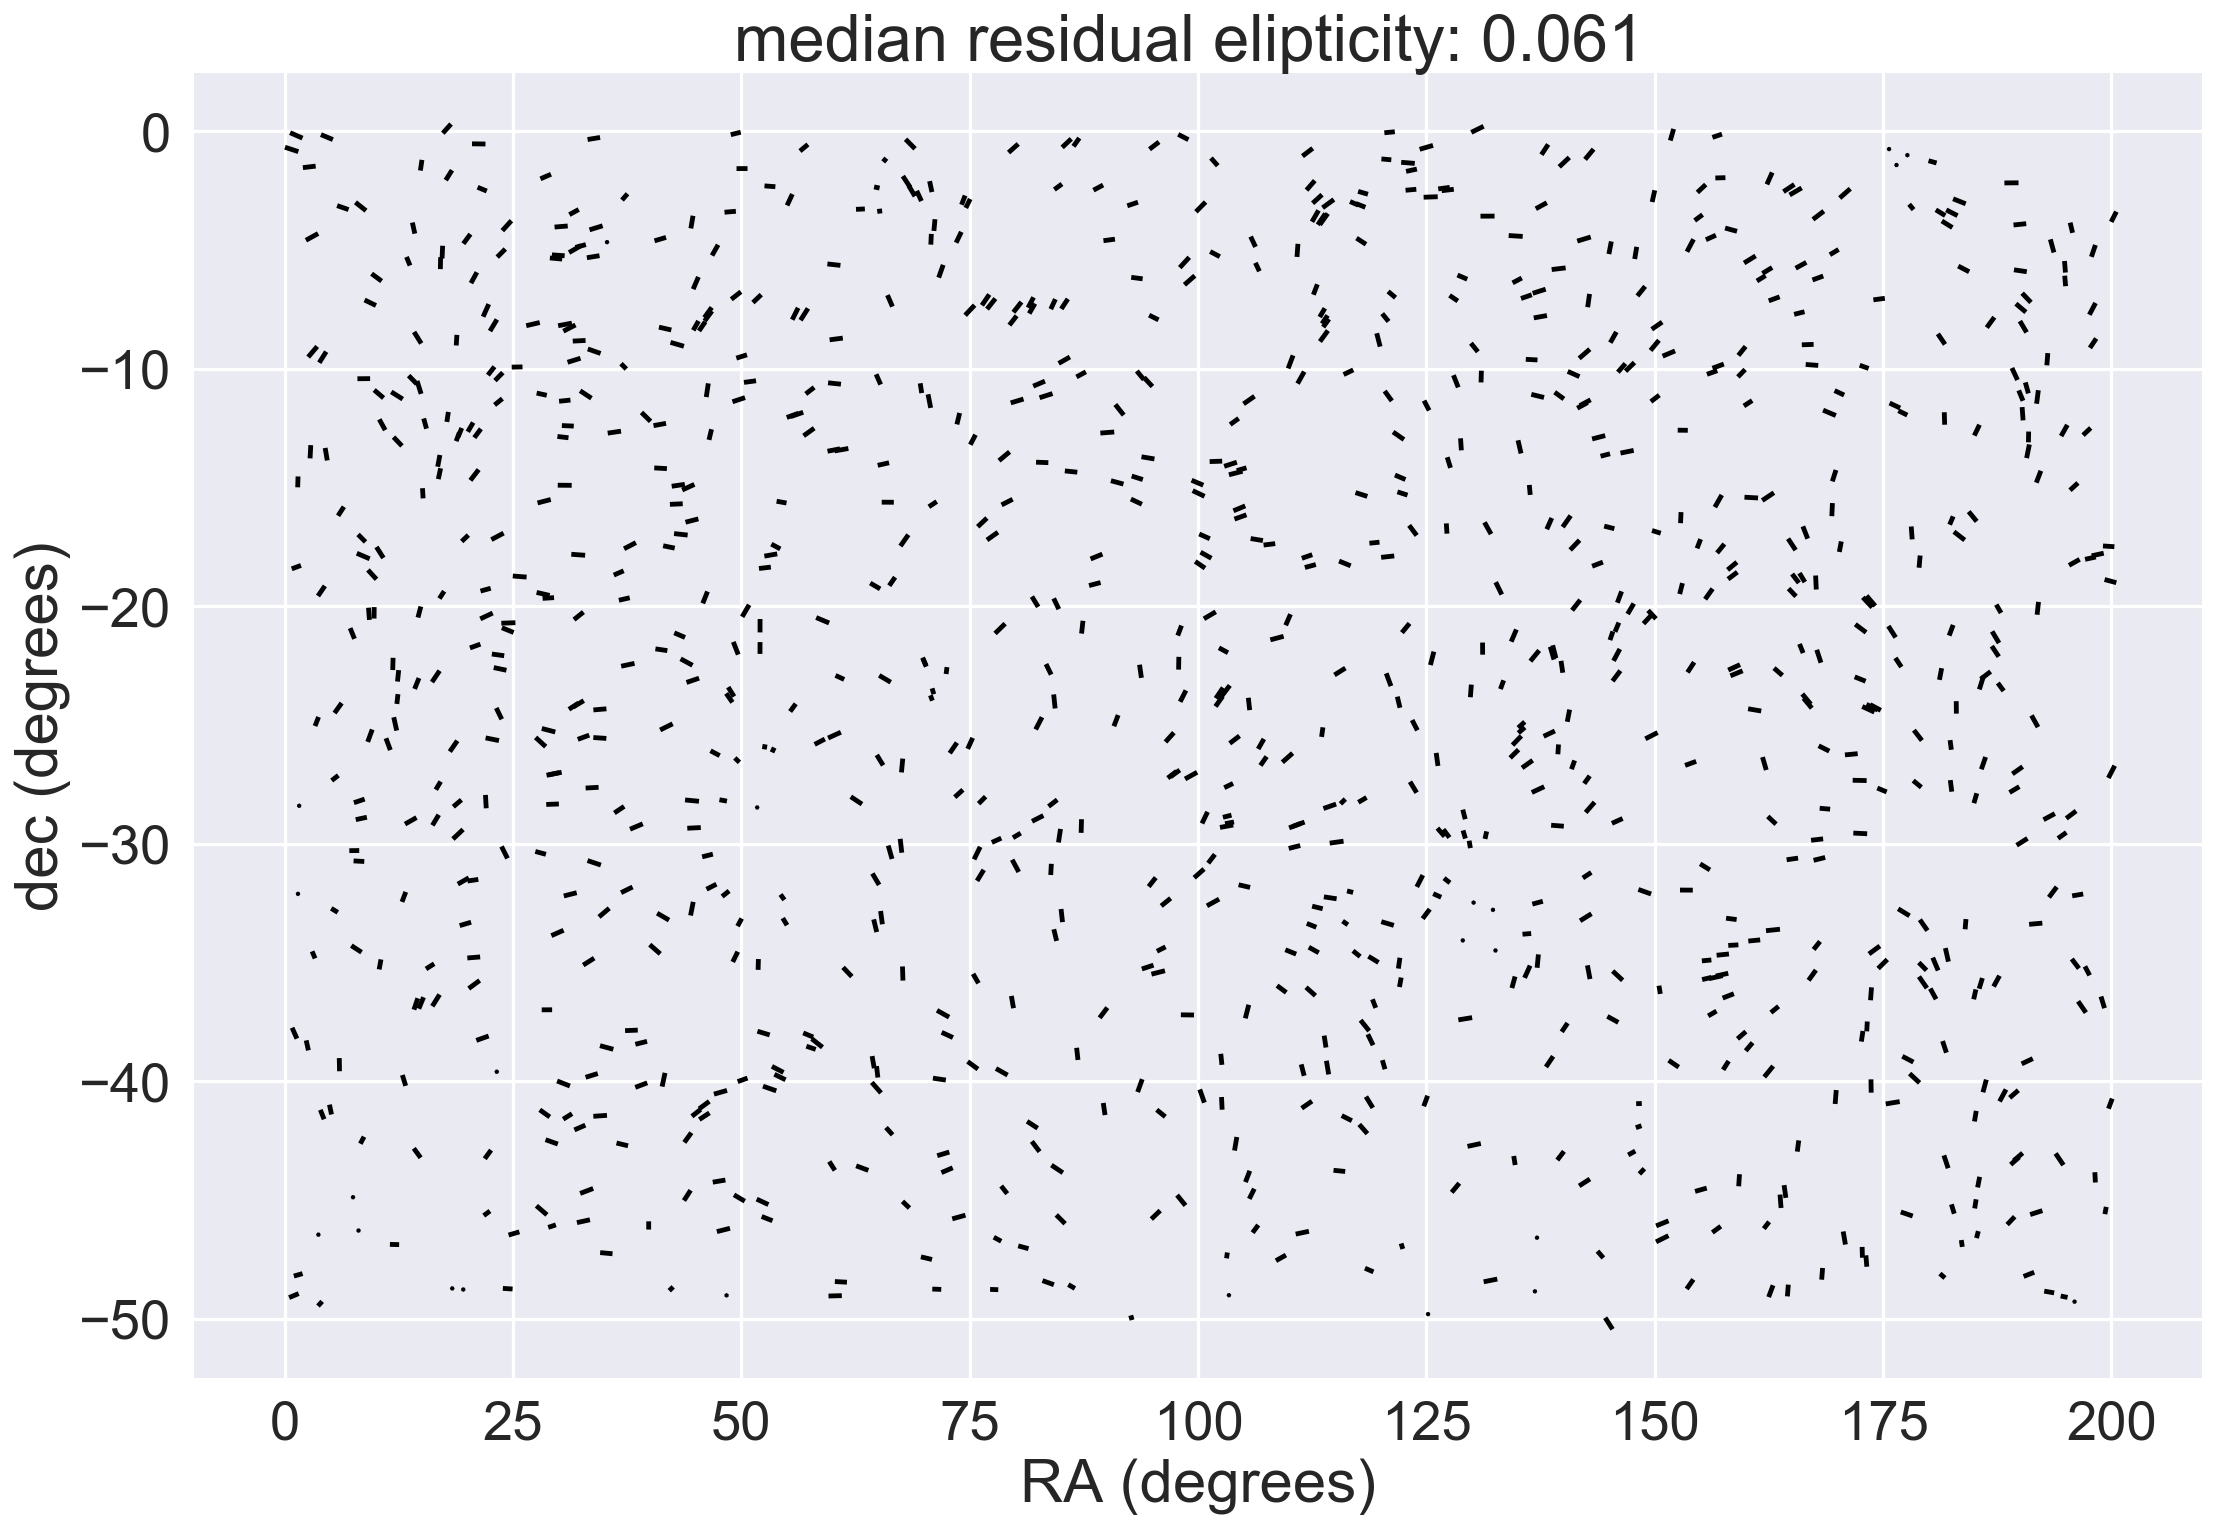

In [296]:
X = np.array(worst_case.PSF.e.keys())[:,0]
Y = np.array(worst_case.PSF.e.keys())[:,1]
e1 = np.array(worst_case.PSF.e.values())[:,0]
e2 = np.array(worst_case.PSF.e.values())[:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=10,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
# qk = plt.quiverkey(Q, 0.8, 0.85, 0.01, r'$|e|=0.01$', labelpos='E', coordinates='figure')
plt.title(r'median residual elipticity: {:.3f} '.format(np.median(U)))
print np.mean(U)

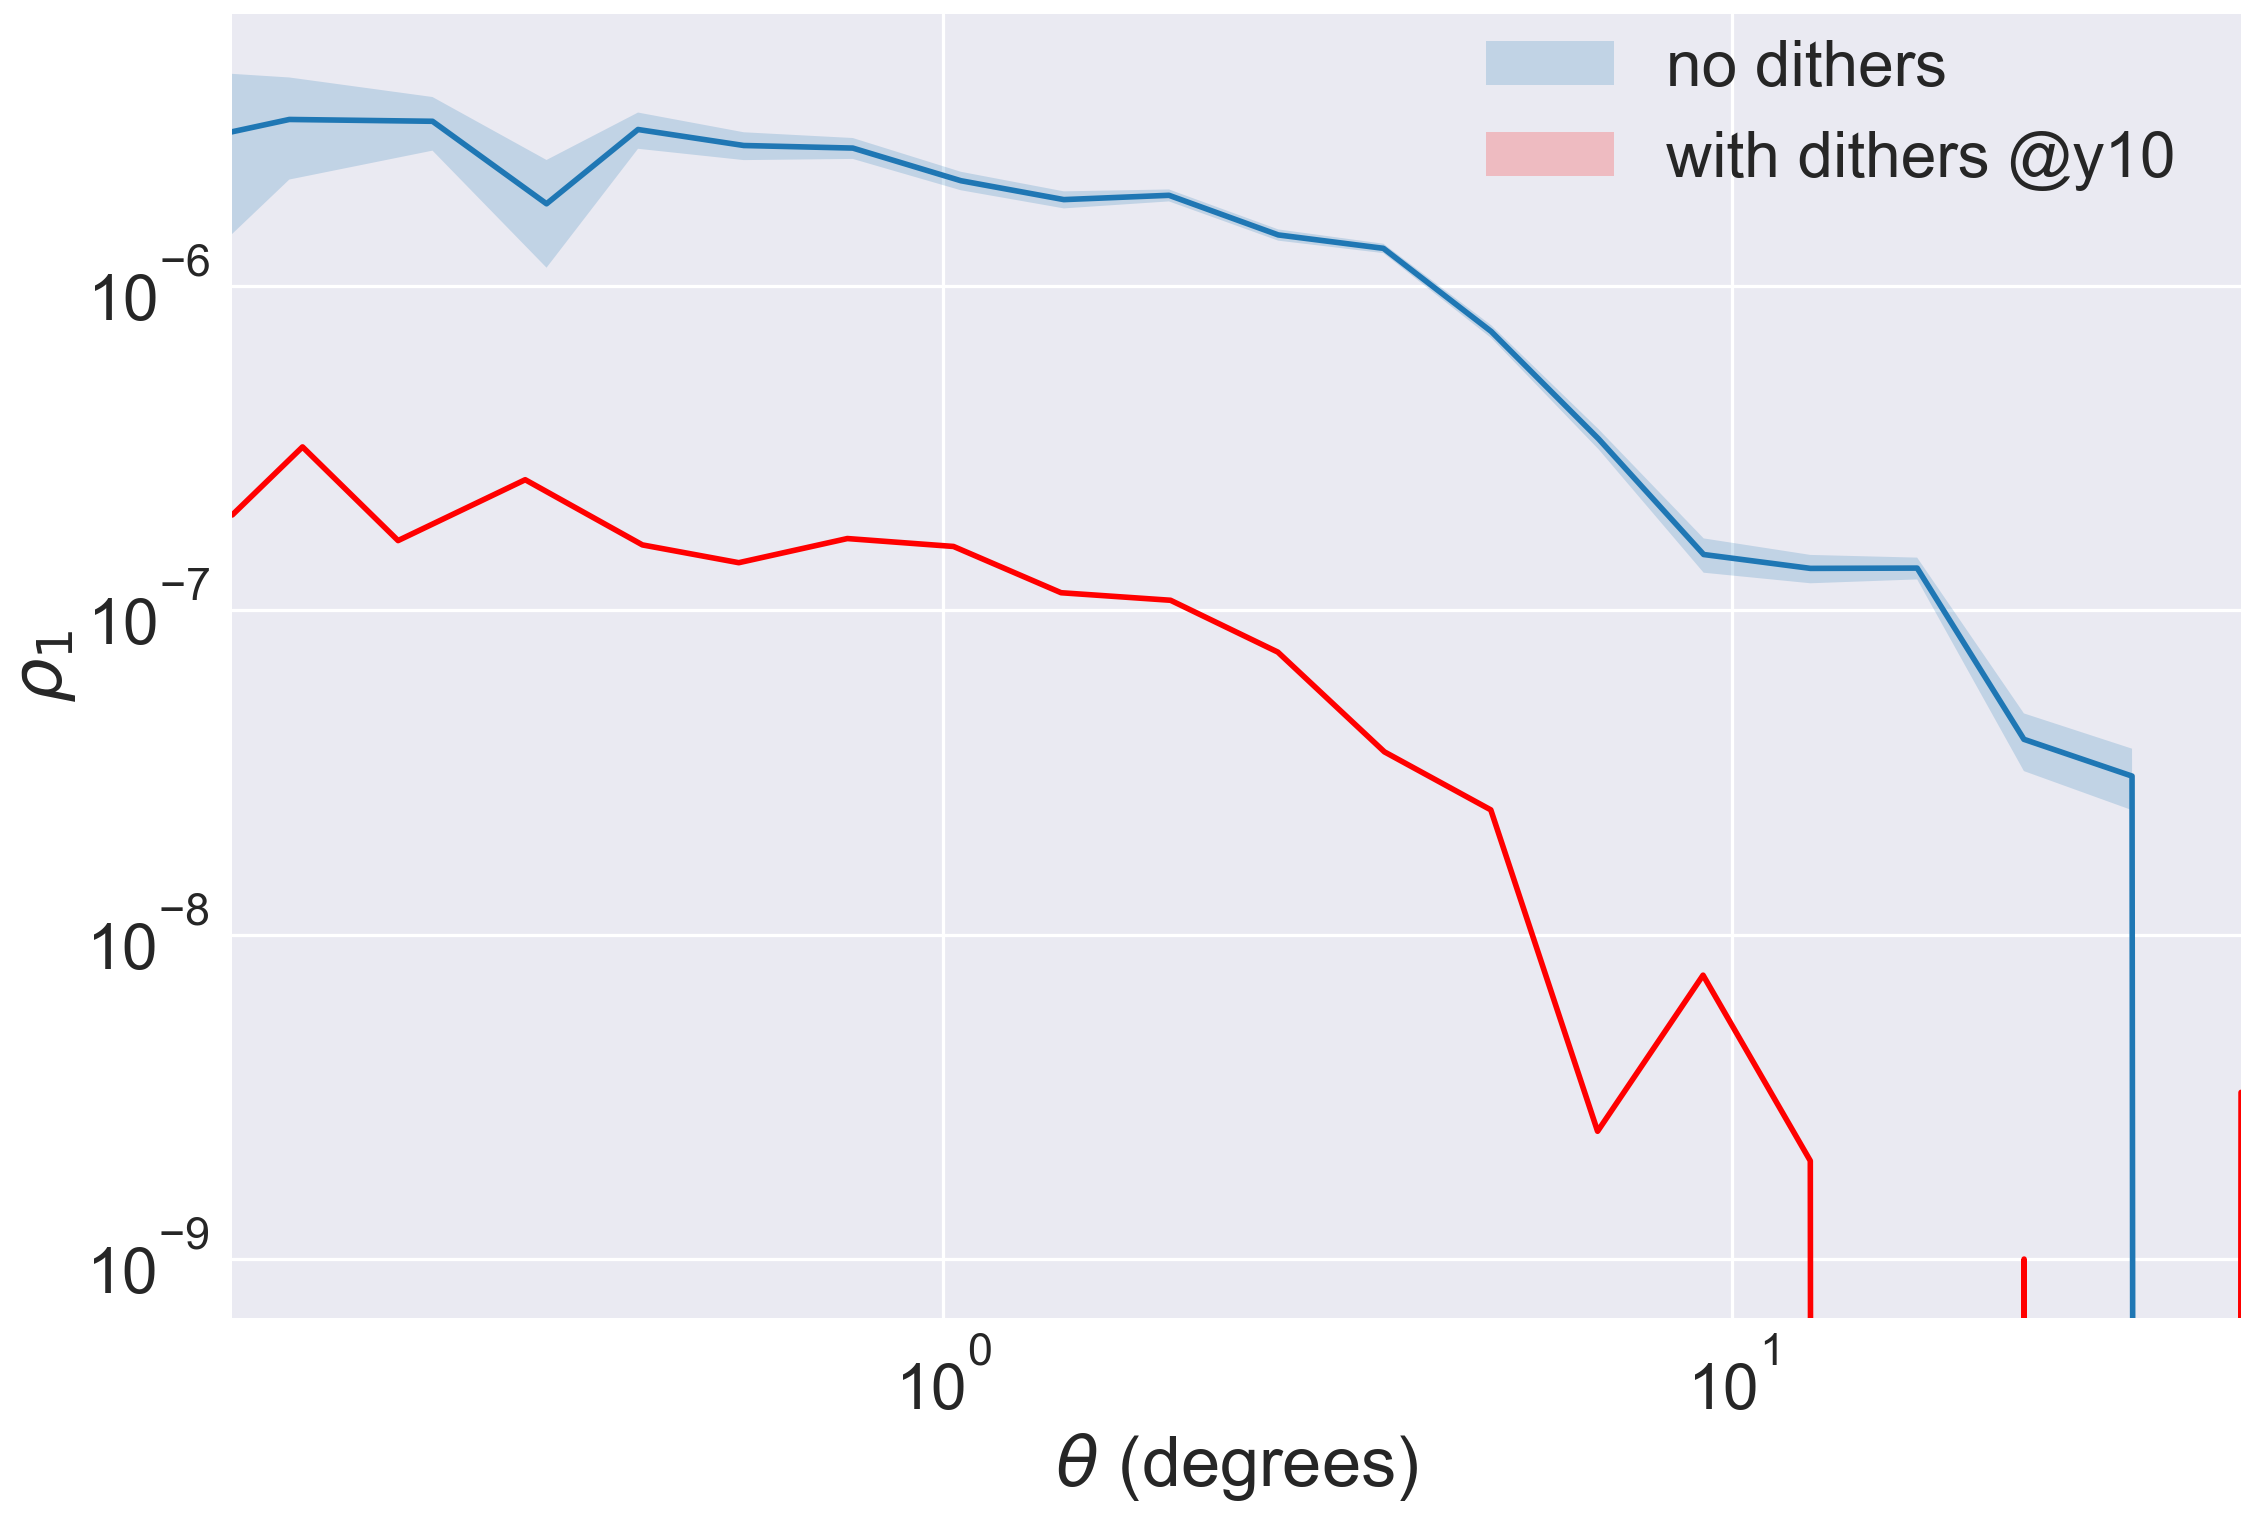

In [41]:
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')

sns.tsplot(best_case.rho1,best_case.r,color='r')
# sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
# plt.yscale('symlog')
# plt.ylim(-1E-5, 5E-3)
plt.legend([r'no dithers',r'with dithers @y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

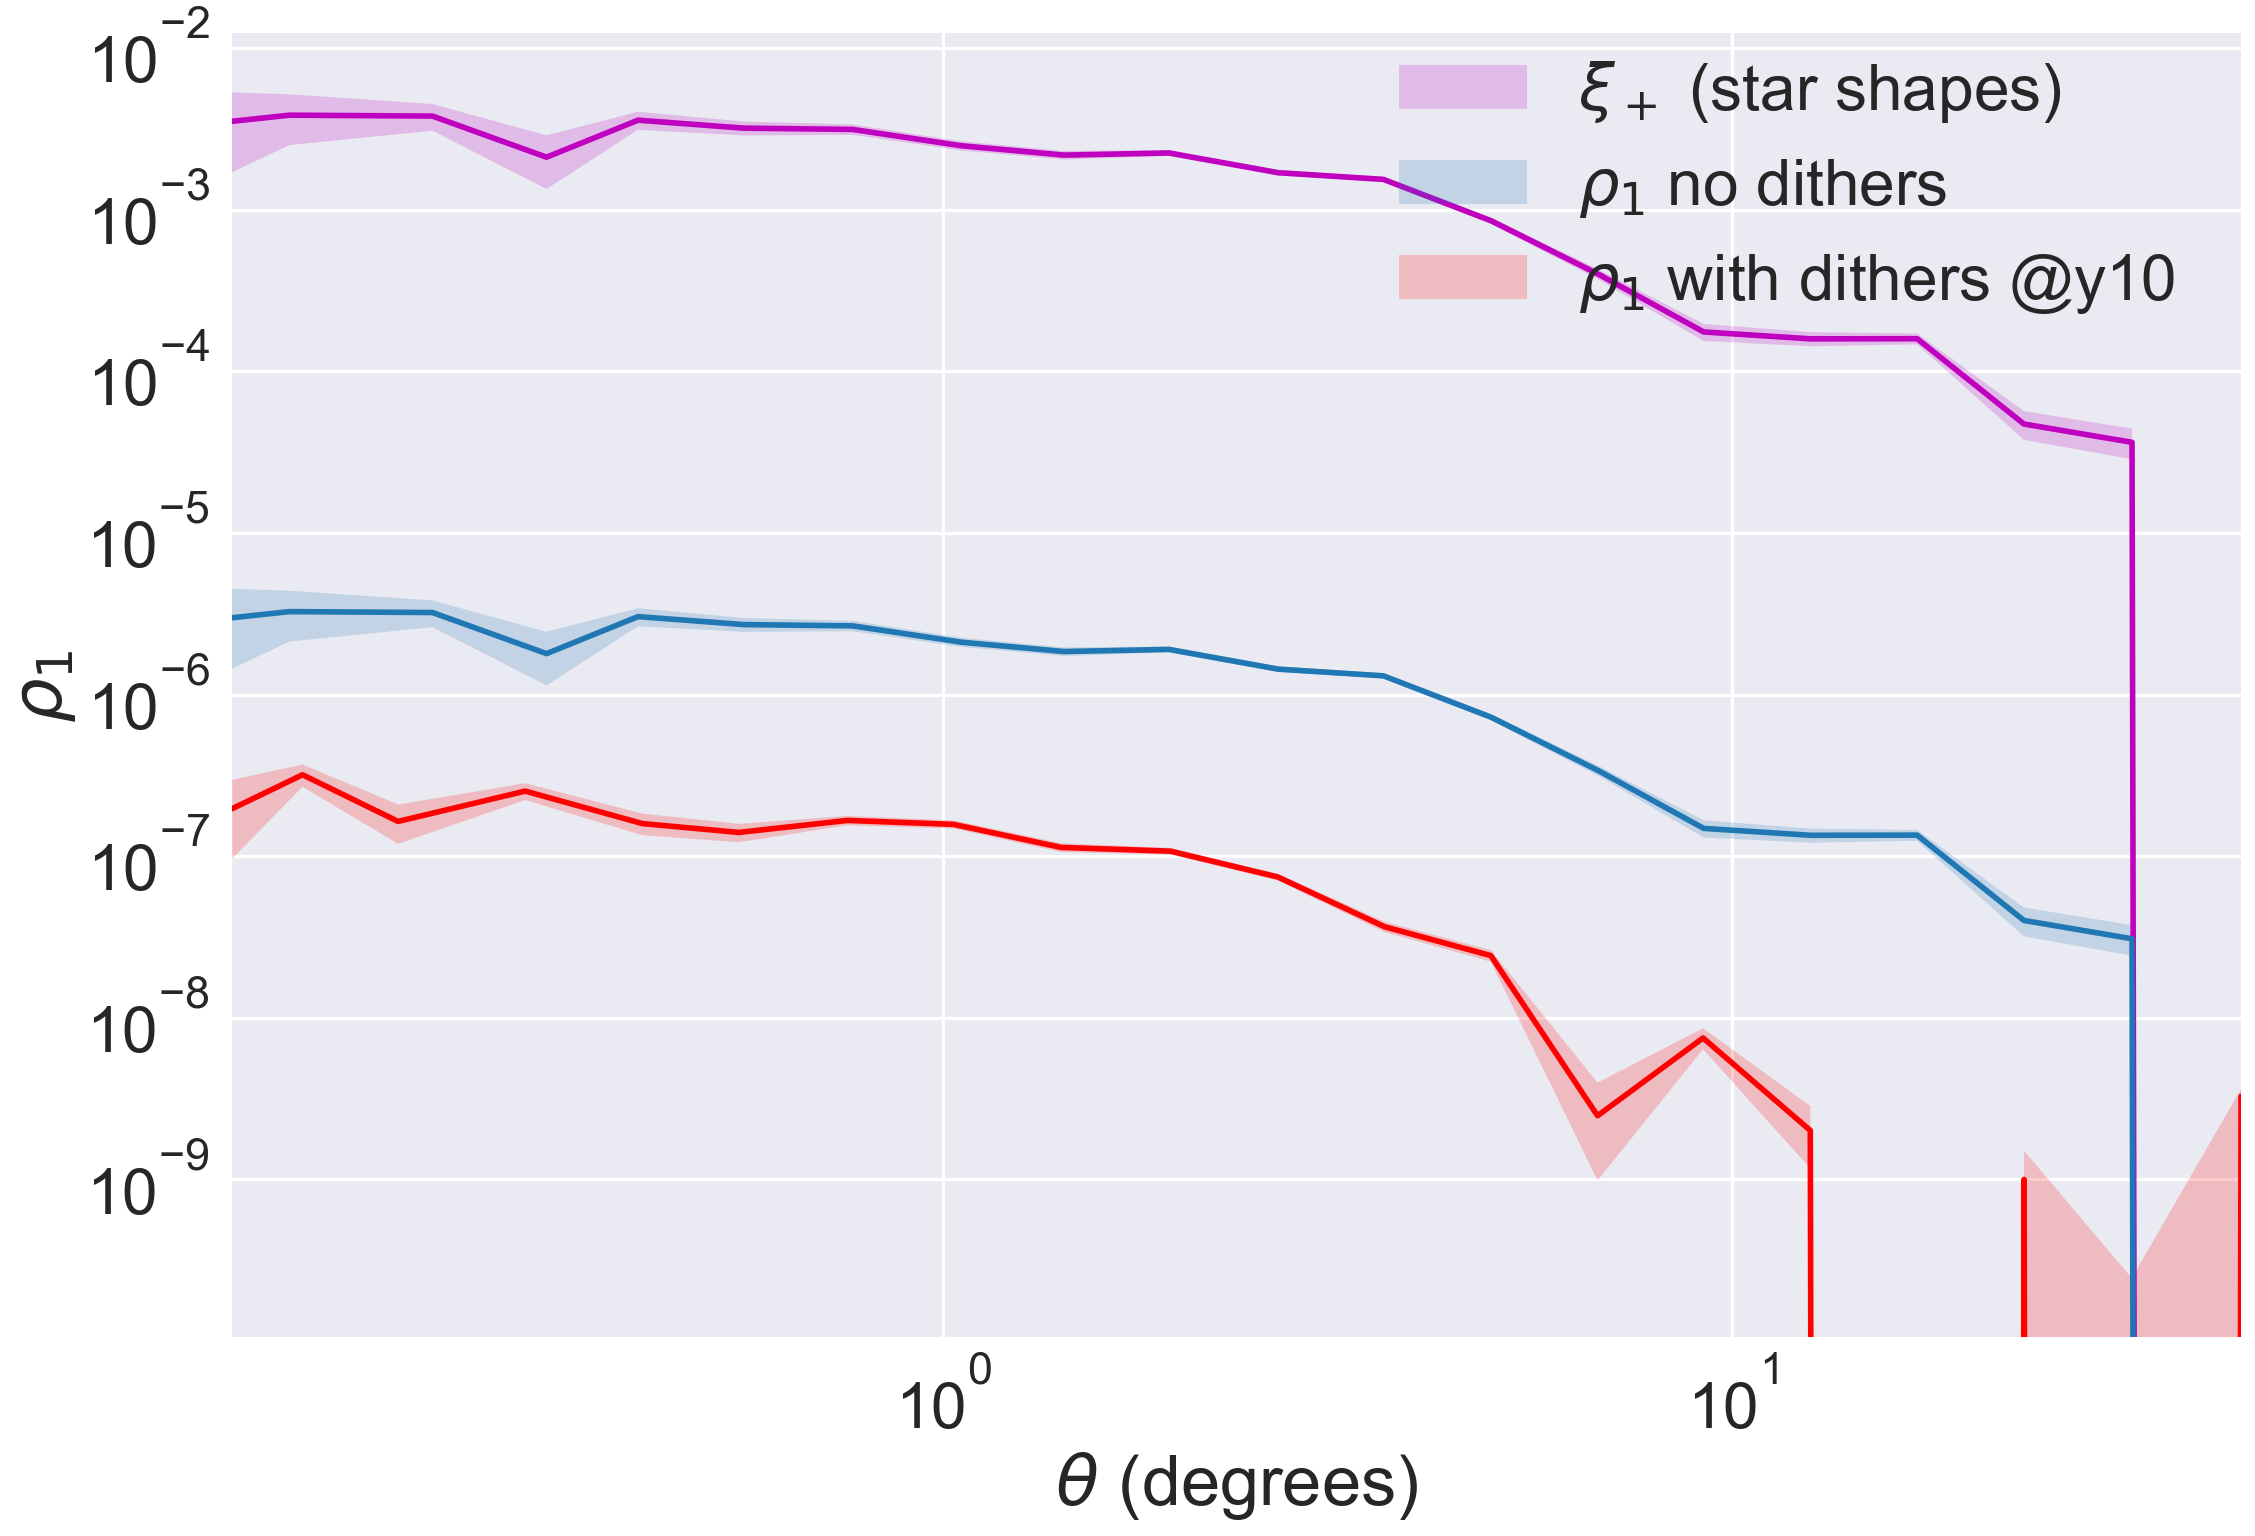

In [56]:

X = np.array(worst_case.STAR.e.keys())[:,0]
Y = np.array(worst_case.STAR.e.keys())[:,1]
e1 = np.array(worst_case.STAR.e.values())[:,0]
e2 = np.array(worst_case.STAR.e.values())[:,1]

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars',color='m')
X = np.array(worst_case.e.keys())[:,0]
Y = np.array(worst_case.e.keys())[:,1]
e1 = np.array(worst_case.e.values())[:,0]
e2 = np.array(worst_case.e.values())[:,1]
angles = np.zeros(len(X))

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')




X = np.array(best_case.DELTA.e.keys())[:,0]
Y = np.array(best_case.DELTA.e.keys())[:,1]
e1 = np.array(best_case.DELTA.e.values())[:,0]
e2 = np.array(best_case.DELTA.e.values())[:,1]

cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=50, nbins=20, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
sns.tsplot(xip,best_case.r,err_style='std_bars',color='r')
# sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\rho_1$')
plt.xscale('log')
plt.yscale('log')
# plt.yscale('symlog')
# plt.ylim(-1E-5, 5E-3)
plt.legend([r'$\xi_+$ (star shapes)',r'$\rho_1$ no dithers',r'$\rho_1$ with dithers @y10'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [130]:
dic = {(1,2):np.array([5,3,2]),(5,7):np.array([1,2,4])}
starMxx = [1,5,3,5]
starMxy = [1,6,5,4]
starMyy = [5,5,6,7]
stars = [(1,2),(5,7),(6,7),(1,1)]

In [124]:
dic = {k:(dic[k]+1 if k in dic.keys() else 1) for k in lst}
dic

{(1, 2): 8, (5, 7): 4, (6, 7): 3}

In [137]:
dic

{(1, 1): array([5, 4, 7]),
 (1, 2): array([6, 4, 7]),
 (5, 7): array([6, 8, 9]),
 (6, 7): array([3, 5, 6])}

In [ ]:
dic = {i}

In [140]:
n = {(1,1):8, (1,2):4, (5,7):2,(6,7):4}

In [141]:
dic = {k:dic[k]/n[k] for k in dic.keys()}

In [142]:
dic

{(1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ])}

In [189]:
dic

{(1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ])}

In [191]:
dic.append(dic)

AttributeError: 'dict' object has no attribute 'append'

In [194]:
dic2 = {k:v*2 for k,v in dic.items()}

In [197]:
dic2[(19,2)]=np.array([9,8,7])

In [220]:
'dic2' in dir(dict)

False

In [221]:
updating empty list python 

SyntaxError: invalid syntax (<ipython-input-221-bb93586f061b>, line 2)

In [224]:
from itertools import chain
context = dict(chain({}.items(), dic.items()))


In [230]:
context = dict(chain(context.items(), dic.items()))
context

{(1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ]),
 (19, 2): array([9, 8, 7])}

In [238]:
a = {(0,0):np.array([0,0,0])}.update(dic)

In [240]:
print a

None


In [242]:
dic.update(dic2)

In [243]:
dic

{(1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ]),
 (19, 2): array([9, 8, 7])}

In [246]:
dic2 = {k:v*2 for k,v in dic2.items()}

In [247]:
dic2

{(1, 1): array([ 1.25,  1.  ,  1.75]),
 (1, 2): array([ 3. ,  2. ,  3.5]),
 (5, 7): array([ 6.,  8.,  9.]),
 (6, 7): array([ 1.5,  2.5,  3. ]),
 (19, 2): array([18, 16, 14])}

In [248]:
dic

{(1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ]),
 (19, 2): array([9, 8, 7])}

In [249]:
print dict(chain(dic.items(), dic2.items()))

{(1, 2): array([ 3. ,  2. ,  3.5]), (19, 2): array([18, 16, 14]), (5, 7): array([ 6.,  8.,  9.]), (6, 7): array([ 1.5,  2.5,  3. ]), (1, 1): array([ 1.25,  1.  ,  1.75])}


In [250]:
dic[0]=5

In [251]:
dic

{0: 5,
 (1, 1): array([ 0.625,  0.5  ,  0.875]),
 (1, 2): array([ 1.5 ,  1.  ,  1.75]),
 (5, 7): array([ 3. ,  4. ,  4.5]),
 (6, 7): array([ 0.75,  1.25,  1.5 ]),
 (19, 2): array([9, 8, 7])}

In [252]:
dic2

{(1, 1): array([ 1.25,  1.  ,  1.75]),
 (1, 2): array([ 3. ,  2. ,  3.5]),
 (5, 7): array([ 6.,  8.,  9.]),
 (6, 7): array([ 1.5,  2.5,  3. ]),
 (19, 2): array([18, 16, 14])}

In [253]:
import pprint

In [257]:
pprint.pprint(defaultdict(chain(dic.items(), dic2.items())))

TypeError: first argument must be callable or None

In [304]:
myBundles = {}
nside = 128
metric = metrics.CountMetric('expMJD')
slicer0 = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec', nside=nside)  
sqlconstraint = 'filter="r"'
stackerList = [stackers.SpiralDitherFieldPerNightStacker(nCoils=7)]
slicer3 = slicers.HealpixSlicer(lonCol='spiralDitherFieldPerNightRa', latCol='spiralDitherFieldPerNightDec', nside=nside)
myBundles['spiral dither'] = metricBundles.MetricBundle(metric, slicer3, sqlconstraint, 
                                                       stackerList=stackerList, runName=runName,
                                                       metadata='spiral dither')

opsdb = db.OpsimDatabase('/Users/myhome/Downloads/minion_1016_sqlite.db')
outDir = 'dither_test'
resultsDb = db.ResultsDb(outDir=outDir)
bgroup = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Querying database with constraint filter="r"
Found 538713 visits
Running:  ['spiral dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [307]:
import os
for b in bgroup.bundleDict.itervalues():
    filename = os.path.join(outDir, b.fileRoot) + '.npz'
    b.read(filename)
pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlconstraint)
pos = np.array(pos)
if any(row[1] == x for row in pos):
    posRA = zip(*pos)[1]
if any(row[2] == x for row in pos):
    posDec = zip(*pos)[2]
pos = np.array((posRA,posDec))
pos = pos.swapaxes(1,0)

plt.plot(pos[:,0],pos[:,1])

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


OverflowError: In draw_path: Exceeded cell block limit

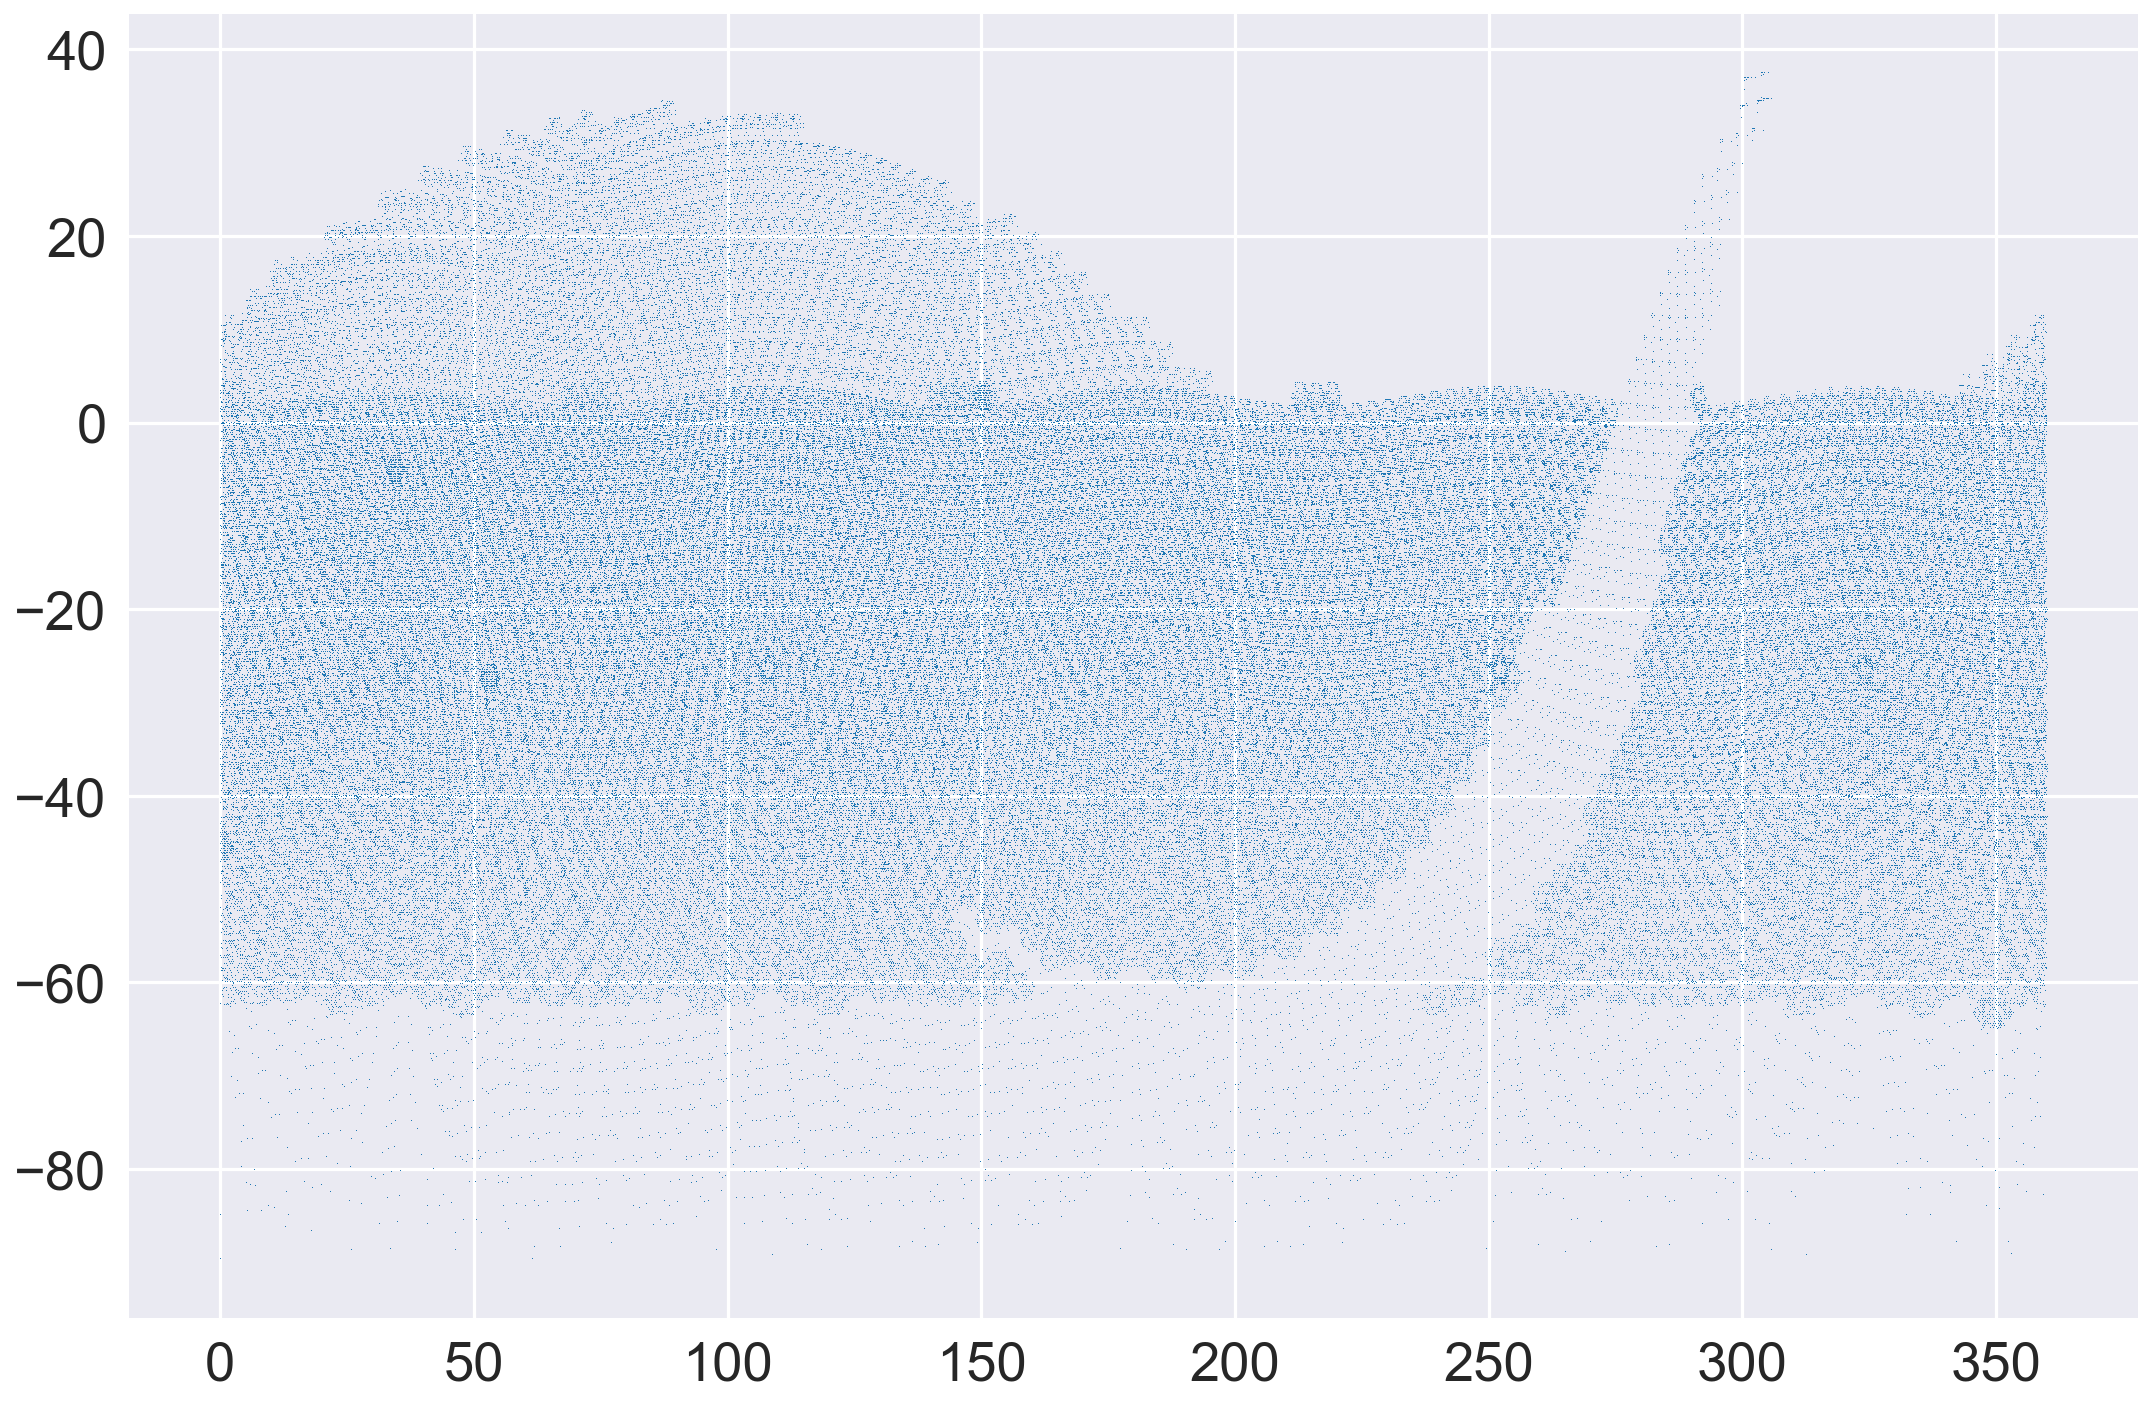

In [312]:
plt.plot(np.degrees(pos[:,0]),np.degrees(pos[:,1]),',')